# **ECG Classification - Gradient Descenders**

Group members:
* Luca Galli (905236)
* Enrico Mannarino (850859)
* Christian Persico (829558)



The following work consists of the application of Deep Learning techniques to classify time series referring to 8528 electrocardiograms (ECGs) classified into 4 different classes by experts in the field (Normal, Atrial Fibrillation, Other Rhythm, Noisy Recording).


The reference dataset (PhysioNet 2017) is available at the following link: https://physionet.org/content/challenge-2017/1.0.0/.

## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics._plot.confusion_matrix import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from os import listdir
from os.path import isfile, join
import zipfile
import collections
from collections import Counter
import os
from sklearn.utils import class_weight
import datetime
import itertools
import math
import random as python_random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.callbacks import EarlyStopping

from google.colab import drive

## Environment Setting

Let's set a seed for replicability of results:

In [ ]:
!PYTHONHASHSEED=123
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(123)

Let's now define the directory containing the compressed datasets:

In [ ]:
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/training2017.zip'
data_folder = '/content/extracted_files'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_folder)

extracted_files = os.listdir(data_folder)
print("Extracted files:", extracted_files)

Mounted at /content/drive
Extracted files: ['training2017']


Let's display the contents of the *training2017* folder:

In [ ]:
file_list = sorted(os.listdir('/content/extracted_files/training2017'))

print("First 10 files:")
for file_name in file_list[:10]:
    print(file_name)

print("\nLast 10 files:")
for file_name in file_list[-10:]:
    print(file_name)

First 10 files:
A00001.hea
A00001.mat
A00002.hea
A00002.mat
A00003.hea
A00003.mat
A00004.hea
A00004.mat
A00005.hea
A00005.mat
\Last 10 files:
A08525.mat
A08526.hea
A08526.mat
A08527.hea
A08527.mat
A08528.hea
A08528.mat
RECORDS
REFERENCE-original.csv
REFERENCE.csv


As we can see, the information about the files is contained in *.mat* format, which is the one we are interested in, but also in *hea* format. The last file, *REFERENCE.csv*, is the file containing the class labels of the observations.

## Importing data

### Loading ECGs

We extract the .mat files from the selected directory, and then create a list, called *mats*, which we fill with the names of the files containing the 8528 sets of ECGs (electrocardiograms).

The file names are strings of the format *AXXXXX.mat*, where *XXXXX* corresponds to a progressive integer identifier for each file.

In [ ]:
folder = '/content/extracted_files/training2017/'

def ismat(filename):
    try:
        ext = filename.split(".")[1]
        if(ext == "mat"):
            return True
        return False
    except:
        return False

mats = [f for f in listdir(folder) if ismat(f)]

size = len(mats)
mats = sorted(mats)
print('Dataset imported. Total  size is', size)

Dataset imported. Total  size is 8528


Now that we have a list of filenames, we create another list (*X_list*) that contains their values. To read the contents of a .mat file in Python, we use the *sio.loadmat()* function on the directory containing the individual file.
Finally, we convert the resulting list into an array (*X_0*):

In [ ]:
X_list = []
for mat in mats:
    X_list.append(sio.loadmat(folder + mat)['val'][0, ])

X_0 = np.array(X_list, dtype=object)

In [ ]:
X_0

array([array([-127, -162, -197, ...,  -18,  -22,  -21], dtype=int16),
       array([128, 157, 189, ...,   0,   1,   2], dtype=int16),
       array([ 56,  73,  85, ..., -64, -36, -20], dtype=int16), ...,
       array([-202, -235, -272, ..., -313, -173,  -52], dtype=int16),
       array([-227, -297, -374, ...,  -54,  -44,  -36], dtype=int16),
       array([-237, -286, -338, ...,  -16,  -17,  -18], dtype=int16)],
      dtype=object)

### Exploratory visualization

Let's visualize the distribution of signal lengths by using an histogram:

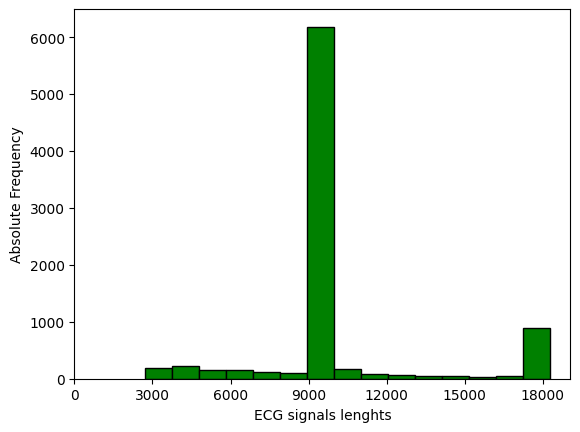

In [ ]:
lengths = [len(arr) for arr in X_0]

plt.hist(lengths, bins='auto', edgecolor='black', color='green')
xticks = list(range(0, max(lengths)+1, 3000))
plt.xticks(xticks, xticks)
plt.xlabel('ECG signals lenghts')
plt.ylabel('Absolute Frequency')

plt.show()

The histogram shows that most of the measurements, made at 300 Hz, are of a length of 9000 (corresponding to 30 seconds). Almost 1000 observations are twice as long (18000+). The other distributions are more negligible.

In [ ]:
print("Min signal length:", min(len(serie) for serie in X_0))
print("Max signal length;", max(len(serie) for serie in X_0))



Min signal length: 2714
Max signal length; 18286


##Pre-processing

### Label assignment

Let us visualize below how the class labels are saved (*REFERENCE.csv* file):

In [ ]:
data_label = pd.read_csv(folder + 'REFERENCE.csv', sep=',', header=None, names=("ID", "Label"))
data_label.head()

,ID,Label
0,A00001,N
1,A00002,N
2,A00003,N
3,A00004,A
4,A00005,A


As expected, we have file names paired with the class label. We can have 4 class labels, as we can see below:

In [ ]:
data_label["Label"].unique()

array(['N', 'A', 'O', '~'], dtype=object)

We proceed by replacing the class labels (4 in total) of each observation with a numerical identifier:

- N (Normal Rhythm) --> 0

- A (Atrial Fibrillation) --> 1

- O (Other Rhythm) --> 2

- ~ (Noisy Recording) --> 3

To do this, we start by creating an array of zeros as large as the total number of .mat files. Then these placeholder values will be replaced by the actual values of the class they belong to (variable *labels_0*).

In [ ]:
labels_0 = np.zeros((size, 1))

for i in range(size):
    if data_label.loc[data_label["ID"] == mats[i][:6]].values[0][1] == 'N':
        labels_0[i] = 0
    elif data_label.loc[data_label["ID"] == mats[i][:6]].values[0][1] == 'A':
        labels_0[i] = 1
    elif data_label.loc[data_label["ID"] == mats[i][:6]].values[0][1] == 'O':
        labels_0[i] = 2
    else:
        labels_0[i] = 3

For instance, these are the first 5 elements of the resulting array:

In [ ]:
labels_0[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

In [ ]:
def plot_class_histogram(labels):
    unique_classes, counts = np.unique(labels, return_counts=True)

    sorted_indices = np.argsort(counts)
    unique_classes = unique_classes[sorted_indices]
    counts = counts[sorted_indices]

    fig, ax = plt.subplots()
    ax.barh(range(len(unique_classes)), counts, color="green")

    categories = ['Normal', 'Other Rhythm', 'Atrial fibrillation','Noisy recording']
    ax.set_yticks(range(len(unique_classes)))
    ax.set_yticklabels(reversed(categories))

    ax.set_title('Class distribution')

    for i, v in enumerate(counts):
        ax.text(v + 100, i, str(v), color='black', va='center')

    ax.set_xlim(right=max(counts) + 1000)

    plt.show()

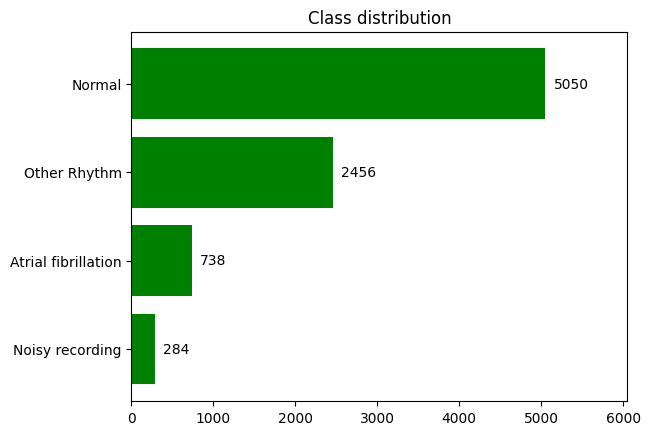

In [ ]:
plot_class_histogram(labels_0)

As we can see the classes are unbalanced. We will take care about this later on.

### Signal selection and division

Since the signals vary in length, ranging from a minimum of 2714 to a maximum of 18286 values, only those greater than or equal to 9000 will be considered; in particular, those with more than 18000 values will be divided into two separate series of length equal to 9000, both with the same label as the original series, while of the others only the first 9000 values were considered.

In [ ]:
X_1 = []
labels_1 = []

block_size = 9000

for i, arr in enumerate(X_0):
    length = len(arr)

    if length < block_size:
        continue

    num_blocks = length // block_size

    for j in range(num_blocks):
        start_idx = j * block_size
        end_idx = (j + 1) * block_size
        X_1.append(arr[start_idx:end_idx])
        labels_1.append(labels_0[i])

X_1 = np.array(X_1)
labels_1 = np.array(labels_1)

Due to the selection and division operations, we went from an initial amount of 8528 observations, to 8409 observations, as computed below.

In [ ]:
len(X_1)

8409

As we verified below, all the signals now have an equal length of 9000.

In [ ]:
# Verifica che la lunghezza di tutte le serie sia pari a 9000

dummy = []
for j in X_1:
    dummy.append(len(j))

set(dummy)

{9000}

### Class analysis

Let's visualize the amount of discarded observations for each class

In [ ]:
obs_del = []

for i in range(len(X_0)):
    if len(X_0[i]) < 9000:
      obs_del.append(labels_0[i])

obs_del = np.array(obs_del)

merged_list = [item for sublist in obs_del for item in sublist]

conteggio = Counter(merged_list)

for variabile, count in conteggio.items():
    print(f"Class {variabile}: {count}")
print("------------------")
print(f"Total discarded observations: {len(obs_del)} out of a total of 8528")

Class 0.0: 521
Class 1.0: 113
Class 2.0: 194
Class 3.0: 139
------------------
Total discarded observations: 967 out of a total of 8528


Let's also visualize the amount of gained observations for each class due to signal truncation

In [ ]:
obs_dup = []

for i in range(len(X_0)):
    if len(X_0[i]) >= 18000:
      obs_dup.append(labels_0[i])

obs_dup = np.array(obs_dup)

merged_list = [item for sublist in obs_dup for item in sublist]

conteggio = Counter(merged_list)

for variabile, count in conteggio.items():
    print(f"Classe {variabile}: {count}")
print("------------------")
print(f"Total truncated observations (split): {len(obs_dup)}")

Classe 0.0: 408
Classe 1.0: 93
Classe 2.0: 341
Classe 3.0: 6
------------------
Total truncated observations (split): 848


We therefore discard a total of 967 - 848 = **119** observations.

The new total number of observations will be 8528 - 119 = **8409** observations.

Let us now visualize the class numerosity of the processed signals after the data selection process:

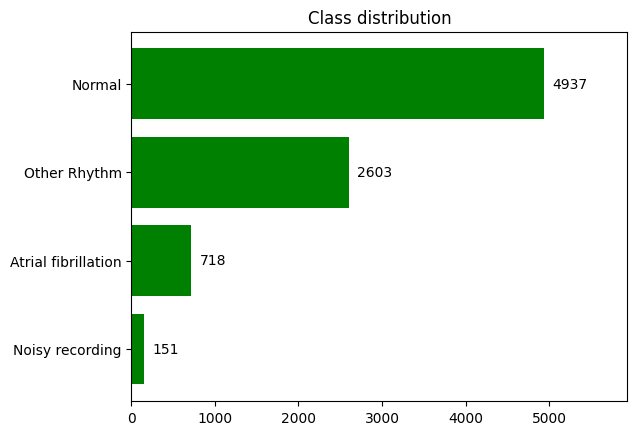

In [ ]:
plot_class_histogram(labels_1)

As we can observe, the classes are still unbalanced. Class imbalance can result in poor predictive performance, especially for the minority class.

To mitigate the class imbalance problems, we try two approaches and compare them:
* **Weighted loss function**: a procedure of assigning different weights for each class in the classification process. In particular, we assign higher weights to minority classes and lower weights to majority classes. In this way, during the training process, misclassification of minority classes results in a higher penalty.
* **Data augmentation**: multiple techniques to generate data in order to obtain balanced classes and allow the model to be able to generalize better (it is important to specify that this will be applied only to the training set).


Note: using class weights changes the range of the loss. This may affect the stability of the training if you use an optimizer whose step size is dependent on the magnitude of the gradient. For this reason, we will use Adam optimizer, which is unaffected by the scaling change. For a fair comparison, Adam classifier will also be used with data augmentation (source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).

Let's see the main descriptive statistics for ECGs separated by class:

In [ ]:
# Definire una funzione per calcolare le statistiche

def calcola_statistiche(indici):
    means = []
    maxs = []
    mins = []
    stds = []
    for indice in indici:
        ecg = Xlist[indice]
        means.append(np.mean(ecg))
        maxs.append(max(ecg))
        mins.append(min(ecg))
        stds.append(np.std(ecg))
    return means, maxs, mins, stds

indici_classe0 = np.where(labels_1 == 0)[0].tolist()
indici_classe1 = np.where(labels_1 == 1)[0].tolist()
indici_classe2 = np.where(labels_1 == 2)[0].tolist()
indici_classe3 = np.where(labels_1 == 3)[0].tolist()

Xlist = X_1.tolist()

classi = [indici_classe0, indici_classe1, indici_classe2, indici_classe3]
for i, classe in enumerate(classi):
    means, maxs, mins, stds = calcola_statistiche(classe)
    print("CLASS {}:".format(i))
    print("Mean: {}".format(round(float(np.mean(means)), 3)))
    print("Mean standard deviation: {}".format(round(float(np.mean(stds)), 3)))
    print("Max: {}".format(max(maxs)))
    print("Min: {}".format(min(mins)))
    print()

CLASS 0:
Mean: 7.845
Mean standard deviation: 199.367
Max: 8318
Min: -10636

CLASS 1:
Mean: 7.72
Mean standard deviation: 183.254
Max: 6342
Min: -6787

CLASS 2:
Mean: 6.889
Mean standard deviation: 196.305
Max: 8257
Min: -7655

CLASS 3:
Mean: 1.655
Mean standard deviation: 397.229
Max: 7309
Min: -6646



The class averages are quite similar to each other except for class 3 (Noisy Recording) which is about 1.7.

The lowest standard deviation was recorded for class 1 (Atrial Fibrillation) while the highest was recorded for class 3, as we might have expected.

We observe that the Atrial Fibrillation (Class 1) measurements have a lower standard deviation than the other classes.

In [ ]:
del mats, X_list, lengths, data_label, labels_0, dummy, Xlist

### One-hot encoding

We apply one-hot encoding for the categorical variable extracted from the 'REFERENCE.csv' file of ECG classes.

The One-Hot Encoding process, applied through the `to_categorical()` command, converts the categorical variable into a corresponding binary vector (binarization) of length equal to the number of classes in the original variable. Each element of the binary vector represents one of the possible classes and takes value 1 if the data match that class, and 0 otherwise.

In [ ]:
labels_2 = to_categorical(labels_1, num_classes=4)

For example, the class (category) of the first observation will be represented as follows:

In [ ]:
print("One-hot encoding: ", labels_2[0])
print("Category (int): ", np.argmax(labels_2, axis=1)[0])

One-hot encoding:  [1. 0. 0. 0.]
Category (int):  0


In [ ]:
del X_0

### Signals visualization

Let's try to visualize one signal per class, to observe characteristics.

- X-axis represents samples, each one collected every 0.0033333 seconds = 3.3333 milliseconds

- Y-axis represents the amplitude of the signal, measured in millivolts (mV)

The unit value of the X axis is such because readings were all collected at a frequency of 300 Hz: this means that an ECG of 9000 observations (points) will correspond to a collecting period of 9000/300=30s, and therefore that 1/300 = 0.0033333s will pass between one data point and the next one.

In [ ]:
elementi_da_cercare = np.array([0,1,2,3])

indici_trovati = []
for elemento in elementi_da_cercare:
    indice = np.argmax(labels_1 == elemento)
    indici_trovati.append(indice)

print(indici_trovati)

[0, 4, 9, 23]


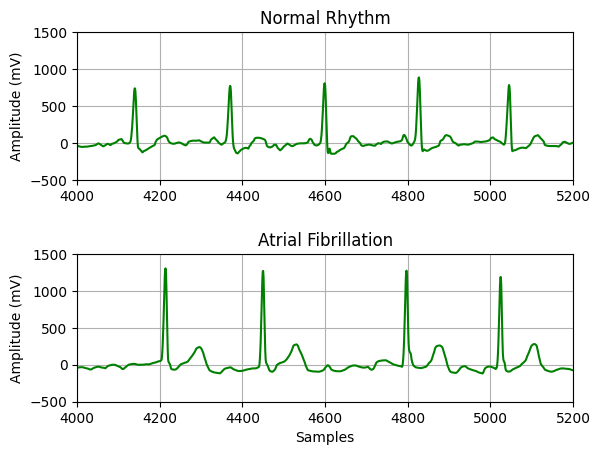

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(X_1[indici_trovati[0]], color="green")
plt.title('Normal Rhythm')
plt.xlim([4000, 5200])
plt.ylim([-500, 1500])
plt.grid()
plt.ylabel('Amplitude (mV)')

plt.subplot(2, 1, 2)
plt.plot(X_1[indici_trovati[1]], color="green")
plt.title('Atrial Fibrillation')
plt.xlim([4000, 5200])
plt.ylim([-500, 1500])
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Amplitude (mV)')

plt.subplots_adjust(hspace=0.5)

plt.show()

Unlike normal rhythm, atrial fibrillation usually has more pronounced peaks, with small, rapid, irregular undulations that demonstrate the altered heartbeat.

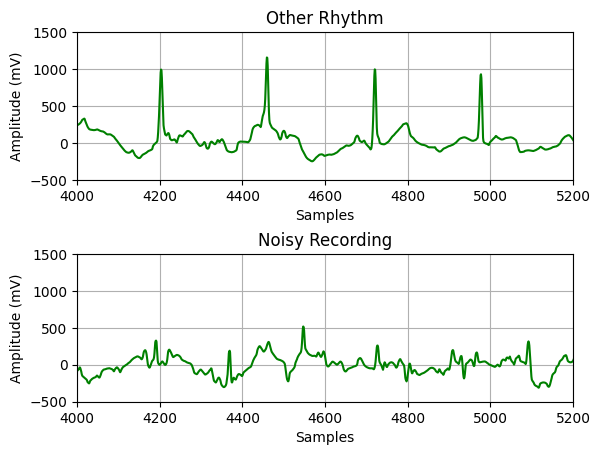

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(X_1[indici_trovati[2]], color="green")
plt.title('Other Rhythm')
plt.xlim([4000, 5200])
plt.ylim([-500, 1500])
plt.grid()
plt.ylabel('Amplitude (mV)')

plt.subplot(2, 1, 2)
plt.plot(X_1[indici_trovati[3]], color="green")
plt.title('Noisy Recording')
plt.xlim([4000, 5200])
plt.ylim([-500, 1500])
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Amplitude (mV)')

plt.subplots_adjust(hspace=0.5)

plt.show()

Uncommon signals are collected under the category *Other Rhythm*, unless there is too much noise to classify them: in this case, physicians have indicated the category *Noisy*.

In [ ]:
del labels_1

## Dataset splitting

The dataset is now divided into training set (60%), validation set (20%) and test set (20%) using stratified random sampling by class (proportions are maintained). Seed 123 is set for replicability of results.

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_1, labels_2, test_size=0.4, stratify=labels_2, random_state=123)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=123)

In [ ]:
grouped_stats = np.sum(y_train, axis=0)

print("Training set class distribution:\n")
for i, count in enumerate(grouped_stats):
    print(f"Class {i}: {int(grouped_stats[i])} elements")

Training set class distribution:

Class 0: 2962 elements
Class 1: 431 elements
Class 2: 1562 elements
Class 3: 90 elements


## Standardization of ECGs

Because of the amplitude of the ECG values, in order to optimize the calculation processes of the models, we perform Z-score standardization on the data. As a result, each series will distribute approximately as a Standard Normal distribution centered on 0, with unit standard deviation.

In [ ]:
scaler = StandardScaler()
X_train_std, X_val_std, X_test_std = scaler.fit_transform(X_train), scaler.fit_transform(X_val), scaler.fit_transform(X_test)

Let's visualize one standardized observation per class:

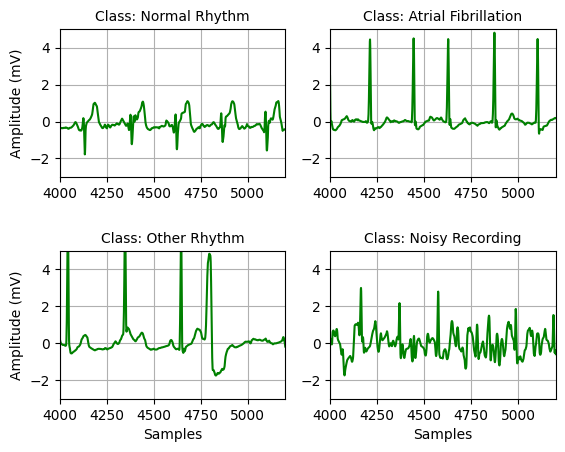

In [ ]:
plt.subplot(2, 2, 1)
plot = plt.plot(X_train_std[1], color="green")
plt.grid()
title = "Class: Normal Rhythm"
plt.xlim([4000, 5200])
plt.ylim([-3, 5])
plt.ylabel('Amplitude (mV)')
plt.title(title, fontsize=10)

plt.subplot(2, 2, 2)
plot = plt.plot(X_train_std[10], color="green")
plt.grid()
title = "Class: Atrial Fibrillation"
plt.xlim([4000, 5200])
plt.ylim([-3, 5])
plt.title(title, fontsize=10)

plt.subplot(2, 2, 3)
plot = plt.plot(X_train_std[0], color="green")
plt.grid()
title = "Class: Other Rhythm"
plt.xlim([4000, 5200])
plt.ylim([-3, 5])
plt.xlabel('Samples')
plt.ylabel('Amplitude (mV)')
plt.title(title, fontsize=10)

plt.subplot(2, 2, 4)
plot = plt.plot(X_train_std[4], color="green")
plt.grid()
title = "Class: Noisy Recording"
plt.xlim([4000, 5200])
plt.ylim([-3, 5])
plt.xlabel('Samples')
plt.title(title, fontsize=10)

plt.subplots_adjust(hspace=0.5)

Let's see the training set size:

In [ ]:
X_train_std.shape

(5045, 9000)

## **Models implementation with weighted loss**

We will start building the first model using the weighted loss approach. We will assign higher weights to the minority class, so that our model gives equal importance to all 4 classes.

We use a naive method to calculate these weights, finding an inverse proportion of each class and using that as the weight:

In [ ]:
y_train_w = np.argmax(y_train, axis=1)

vals_dict = {}
for i in y_train_w:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}

print(weight_dict)

{2: 0.690386521308226, 0: 0.41288404360753217, 3: 0.9821605550049554, 1: 0.9145688800792864}


As we can see, the more numerous a class is (e.g. class 0) the less weight it has (0.41) and vice versa (class 3: 0.98).

### **V1 Model**: 3Conv, 1Dense

Let's start with a base model which consists in three 1-Dimensional convolutions. Every convolution slides *n* parallel kernels of size 3 on the signal and performs dot product, to detect important features and extract them in feature maps: a ReLU activation function is then applied to all the *n* feature maps (one per filter), for introducing nonlinearity.

The number of filters (different kernels producing different feature maps from the same signal) doubles at every convolutional layer, so that the CNN progressively elaborates more complex patterns.

After each of the first two Convolution+ReLU layers, a 1-Dimensional MaxPooling layer is applied, to retain the most important features while reducing dimensionality. We use a pool window of size 3, which summarizes 3 values in 1 value which is the maximum between the three, and then slides with a step size of 3.

The third convolutional layer, instead, is followed by a Global 1-Dimensional MaxPooling, which is a regular MaxPooling, but with the pool size equal to the input size: the whole feature map is summarized by its maximum.

After that, we have a dense layer (fully-connected) for classification, with an output dimensionality of 64.

Last dense layer uses a softmax activation function, that makes sure the CNN outputs sum to 1: this is how we scale model outputs into class probabilities.

In [ ]:
num_classes = 4
TIME_STEPS = X_train_std.shape[1]
NUM_FEATURES = 1

In [ ]:
inputs = keras.Input((TIME_STEPS, NUM_FEATURES))

x = inputs
x = keras.layers.Conv1D(32, 3)(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling1D(3, strides=3)(x)

x = keras.layers.Conv1D(64, 3)(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling1D(3, strides=3)(x)

x = keras.layers.Conv1D(128, 3)(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling1D()(x)

x = keras.layers.Dense(64, activation="relu")(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net_v1 = keras.Model(inputs, outputs)

# SUMMARY
net_v1.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 9000, 1)]         0         
                                                                 
 conv1d_36 (Conv1D)          (None, 8998, 32)          128       
                                                                 
 activation_40 (Activation)  (None, 8998, 32)          0         
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 2999, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_37 (Conv1D)          (None, 2997, 64)          6208      
                                                                 
 activation_41 (Activation)  (None, 2997, 64)          0         
                                                           

We compile the network with Categorical Crossentropy loss function. We use an Adam optimizer, which works good with weighted loss function as previously mentioned, with a learning rate of 0.001.

In [ ]:
net_v1.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])

We use EarlyStopping, which monitors the loss of the validation set at every epoch: if it stops decreasing (improving) for 10 epochs, the training stops. This method saves time and resources, but also mitigates the risk of overfitting caused by overtraining.

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

start = datetime.datetime.now()

history = net_v1.fit(X_train_std, y_train,
                          validation_data=(X_val_std, y_val),
                          epochs=50,
                          callbacks=[callback],
                          class_weight = weight_dict)

end = datetime.datetime.now()
print("Total execution time is: ", end-start)

Epoch 1/50
158/158 [==============================] - 6s 22ms/step - loss: 0.6427 - accuracy: 0.5148 - auc_9: 0.7963 - precision_9: 0.5600 - recall_9: 0.1017 - val_loss: 0.9975 - val_accuracy: 0.5844 - val_auc_9: 0.8346 - val_precision_9: 0.6733 - val_recall_9: 0.0809
Epoch 2/50
158/158 [==============================] - 3s 22ms/step - loss: 0.6000 - accuracy: 0.5685 - auc_9: 0.8245 - precision_9: 0.6416 - recall_9: 0.1217 - val_loss: 0.9461 - val_accuracy: 0.6177 - val_auc_9: 0.8519 - val_precision_9: 0.6949 - val_recall_9: 0.1950
Epoch 3/50
158/158 [==============================] - 3s 20ms/step - loss: 0.5874 - accuracy: 0.5877 - auc_9: 0.8366 - precision_9: 0.6700 - recall_9: 0.2149 - val_loss: 0.9090 - val_accuracy: 0.6249 - val_auc_9: 0.8557 - val_precision_9: 0.6889 - val_recall_9: 0.4489
Epoch 4/50
158/158 [==============================] - 3s 20ms/step - loss: 0.5786 - accuracy: 0.5889 - auc_9: 0.8399 - precision_9: 0.6643 - recall_9: 0.2993 - val_loss: 0.9888 - val_accuracy: 

In [ ]:
evaluation_train = net_v1.evaluate(X_train_std, y_train)
evaluation_val = net_v1.evaluate(X_val_std, y_val)
print(f'Train accuracy : {evaluation_train[1] * 100:.2f}%')
print(f'Validation accuracy : {evaluation_val[1] * 100:.2f}%')

Exception ignored in: <function _xla_gc_callback at 0x7d68b04ef7f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


53/53 [==============================] - 0s 9ms/step - loss: 0.8613 - accuracy: 0.6034 - auc_9: 0.8654 - precision_9: 0.6343 - recall_9: 0.5589
Train accuracy : 72.59%
Validation accuracy : 60.34%


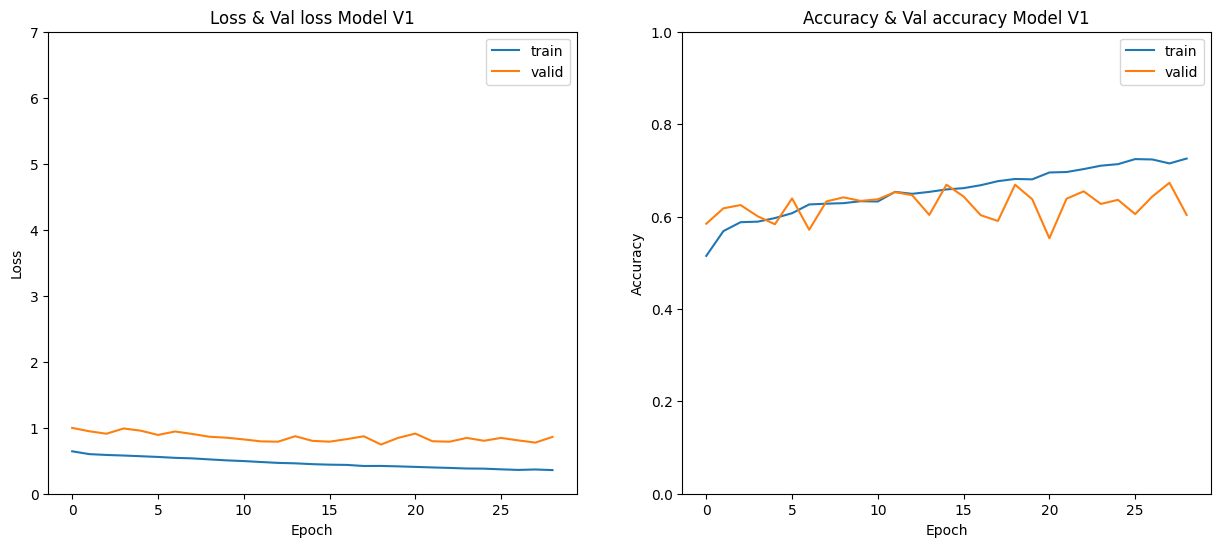

In [ ]:
# PLOT THE LEARNING CURVES
plt.figure(figsize=(15,6))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 7.0])
plt.title("Loss & Val loss Model V1")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V1")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

We observe low accuracies and strong fluctuations on the validation set accuracy.

53/53 [==============================] - 0s 6ms/step


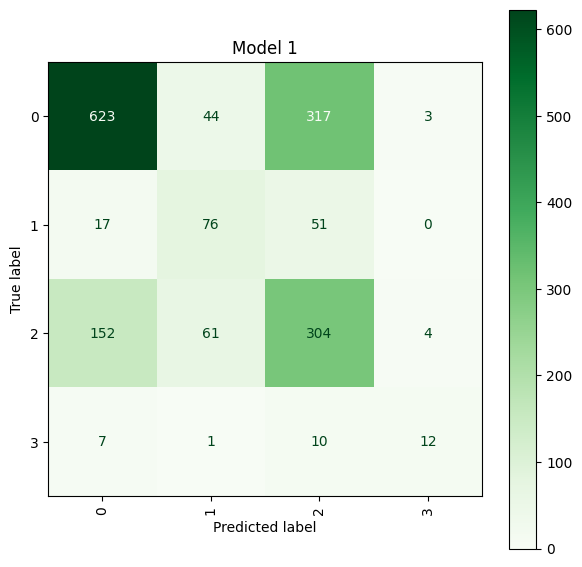

In [ ]:
y_pred = net_v1.predict(X_val_std)

decoded_value_val = np.argmax(y_val, axis = 1)
decoded_value_pred = np.argmax(y_pred, axis = 1)

conf = confusion_matrix(decoded_value_val, decoded_value_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['0', '1', '2', '3'])
fig, ax = plt.subplots(figsize=(7, 7))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='Greens')

plt.title('Model 1')
plt.show()

In [ ]:
file_modelV1 = "/content/drive/MyDrive/Saved_Models/modelV1.h5"
tf.keras.models.save_model(net_v1, file_modelV1)

### **V2 Model**: +1Conv +1Dense

Lets try to increase the complexity of the network by adding a convolutional layer and a dense layer. We also change the number of filters and the size of the kernels in convolutions to accommodate a more complex and resource-expensive network: we now use a fixed kernel size of 5 with a stride (step size) of 2.

As mentioned earlier, the number of filters we use increases (32, 64, 128...) because usually the raw data is noisy, so initially we use fewer filters because we want to extract patterns from the raw data. Then in subsequent levels we combine the obtained patterns to get larger and more complex patterns: at this point we will need more filters to process more complex abstractions.

Specifically, as the complexity of the layer increases, we double the number of filters from the previous layer while keeping the size of the kernels fixed. Alternatively, we can keep the number of filters fixed and decrease the size of the kernels from level to level, for example by halving it.

The additional dense layer was added after the previous Dense layer, with the same output size. In addition to that, both Dense layers weights are now initialized with values from a normal distribution, since inappropriate values will lead to divergence or a slow-down in the training of your neural network. For example, it helps avoiding exploding or vanishing gradients.

Maxpooling layers are now after every convolutional layer, with smaller pool size, to make the network more sensitive to small patterns and local features.

In [ ]:
inputs = keras.Input((TIME_STEPS, NUM_FEATURES))

x = inputs
x = keras.layers.Conv1D(16, 5, strides=2)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(2)(x)

x = keras.layers.Conv1D(32, 5, strides=2)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(2)(x)

x = keras.layers.Conv1D(64, 5, strides=2)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(2)(x)

x = keras.layers.Conv1D(128, 5, strides=2)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(2)(x)

x = keras.layers.GlobalMaxPooling1D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_initializer='normal')(x)

x = keras.layers.Dense(64, activation="relu", kernel_initializer='normal')(x)


outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net_v2 = keras.Model(inputs, outputs)

# SUMMARY
net_v2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 9000, 1)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 4498, 16)          96        
                                                                 
 activation_3 (Activation)   (None, 4498, 16)          0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2249, 16)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 1123, 32)          2592      
                                                                 
 activation_4 (Activation)   (None, 1123, 32)          0         
                                                           

In [ ]:
net_v2.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

start = datetime.datetime.now()

history = net_v2.fit(X_train_std, y_train,
                          validation_data=(X_val_std, y_val),
                          epochs=50,
                          callbacks=[callback],
                          class_weight = weight_dict)

end = datetime.datetime.now()
print("Total execution time is: ", end-start)

Epoch 1/50
158/158 [==============================] - 5s 14ms/step - loss: 0.6134 - accuracy: 0.5719 - auc_1: 0.8246 - precision_1: 0.6971 - recall_1: 0.1647 - val_loss: 0.8961 - val_accuracy: 0.6397 - val_auc_1: 0.8706 - val_precision_1: 0.8081 - val_recall_1: 0.3430
Epoch 2/50
158/158 [==============================] - 2s 10ms/step - loss: 0.4763 - accuracy: 0.6858 - auc_1: 0.8967 - precision_1: 0.7406 - recall_1: 0.5596 - val_loss: 0.6721 - val_accuracy: 0.7176 - val_auc_1: 0.9190 - val_precision_1: 0.7605 - val_recall_1: 0.6344
Epoch 3/50
158/158 [==============================] - 2s 12ms/step - loss: 0.4178 - accuracy: 0.7269 - auc_1: 0.9197 - precision_1: 0.7590 - recall_1: 0.6385 - val_loss: 0.6122 - val_accuracy: 0.7580 - val_auc_1: 0.9334 - val_precision_1: 0.7806 - val_recall_1: 0.7004
Epoch 4/50
158/158 [==============================] - 2s 13ms/step - loss: 0.3883 - accuracy: 0.7433 - auc_1: 0.9291 - precision_1: 0.7736 - recall_1: 0.6862 - val_loss: 0.6103 - val_accuracy: 

In [ ]:
evaluation_train = net_v2.evaluate(X_train_std, y_train)
evaluation_val = net_v2.evaluate(X_val_std, y_val)
print(f'Train accuracy : {evaluation_train[1] * 100:.2f}%')
print(f'Validation accuracy : {evaluation_val[1] * 100:.2f}%')

53/53 [==============================] - 0s 5ms/step - loss: 0.9900 - accuracy: 0.7539 - auc_1: 0.9215 - precision_1: 0.7551 - recall_1: 0.7533
Train accuracy : 93.46%
Validation accuracy : 75.39%


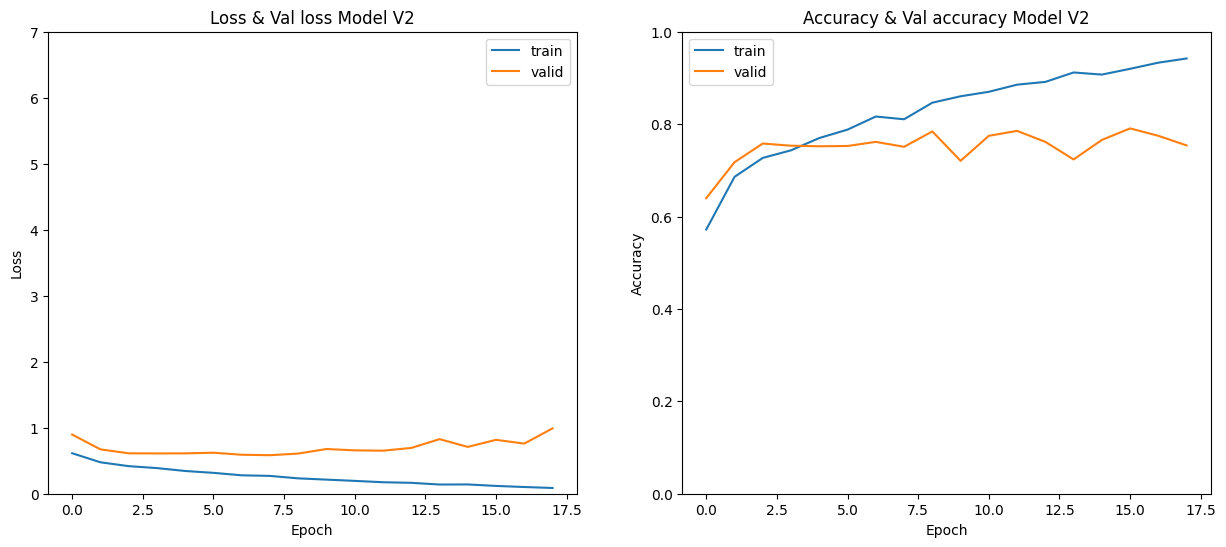

In [ ]:
plt.figure(figsize=(15,6))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 7.0])
plt.title("Loss & Val loss Model V2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V2")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

53/53 [==============================] - 0s 4ms/step


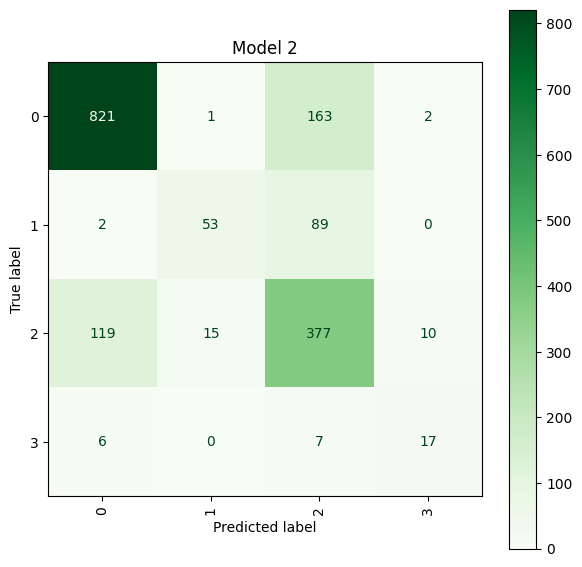

In [ ]:
y_pred = net_v2.predict(X_val_std)

decoded_value_val = np.argmax(y_val, axis = 1)
decoded_value_pred = np.argmax(y_pred, axis = 1)

conf = confusion_matrix(decoded_value_val, decoded_value_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['0', '1', '2', '3'])
fig, ax = plt.subplots(figsize=(7, 7))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='Greens')

plt.title('Model 2')
plt.show()

Increasing complexity has improved accuracies by a lot, but we observe overfitting and fluctuations on the validation set accuracy, which we would want to stabilize.

In [ ]:
file_modelV2 = "/content/drive/MyDrive/Saved_Models/modelV2.h5"
tf.keras.models.save_model(net_v2, file_modelV2)

### **V3 Model**: +Dropout +Dynamic LR

Making the network more complex greatly increased the accuracy. However, we notice two problems by viewing the graphs:

 * Looking at the accuracy graph, we have fluctuations on the validation set. Attempts at normalization (batch) or regularization did not improve the situation. Another hypothesis might be to try lowering the learning rate. For this, we implement `ReduceLROnPlateau()`, which reduces the learning rate (dividing it by 10) if the validation loss does not improve, instead of early stopping the training. We will expect fewer and fewer oscillations as epochs increase. We will observe validation loss with a patience of 5.
 * Again looking at the accuracy graph, there seems to be some overfitting that increases as epochs progress. We try to reduce it by introducing dropout regularization.


 With dropout layers, which we introduced after each convolutional or dense layer, 20% of the layer outputs are randomly ignored (dropped) during training. This results in the layer appearing to have a different number of nodes and connectedness to the preceding layer. This is done because units may change in a way that they fix up the mistakes of the other units. This in turn leads to overfitting because these co-adaptations do not generalize to unseen data.

In [ ]:
inputs = keras.Input((TIME_STEPS, NUM_FEATURES))

x = inputs
x = keras.layers.Conv1D(16, 5, strides=2)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(2)(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv1D(32, 5, strides=2)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(2)(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv1D(64, 5, strides=2)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(2)(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv1D(128, 5, strides=2)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(2)(x)


x = keras.layers.GlobalMaxPooling1D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(64, activation="relu", kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net_v3 = keras.Model(inputs, outputs)

# SUMMARY
net_v3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9000, 1)]         0         
                                                                 
 conv1d_7 (Conv1D)           (None, 4498, 16)          96        
                                                                 
 activation_7 (Activation)   (None, 4498, 16)          0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 2249, 16)         0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 2249, 16)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 1123, 32)          2592      
                                                           

In [ ]:
net_v3.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
callback = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                             patience=5,
                                             min_lr=0.000001)

start = datetime.datetime.now()

history = net_v3.fit(X_train_std, y_train,
                          validation_data=(X_val_std, y_val),
                          epochs=50,
                          callbacks=[callback],
                          class_weight = weight_dict)

end = datetime.datetime.now()
print("Total execution time is: ", end-start)

Epoch 1/50
158/158 [==============================] - 6s 14ms/step - loss: 0.6425 - accuracy: 0.5146 - auc_2: 0.7961 - precision_2: 0.5668 - recall_2: 0.0892 - val_loss: 0.9745 - val_accuracy: 0.5868 - val_auc_2: 0.8424 - val_precision_2: 0.7035 - val_recall_2: 0.1326 - lr: 0.0010
Epoch 2/50
158/158 [==============================] - 1s 9ms/step - loss: 0.5762 - accuracy: 0.5784 - auc_2: 0.8391 - precision_2: 0.6609 - recall_2: 0.2805 - val_loss: 0.8872 - val_accuracy: 0.6415 - val_auc_2: 0.8702 - val_precision_2: 0.7870 - val_recall_2: 0.3603 - lr: 0.0010
Epoch 3/50
158/158 [==============================] - 2s 9ms/step - loss: 0.5152 - accuracy: 0.6347 - auc_2: 0.8709 - precision_2: 0.7155 - recall_2: 0.4501 - val_loss: 0.7701 - val_accuracy: 0.6974 - val_auc_2: 0.9057 - val_precision_2: 0.8234 - val_recall_2: 0.4518 - lr: 0.0010
Epoch 4/50
158/158 [==============================] - 2s 10ms/step - loss: 0.4897 - accuracy: 0.6575 - auc_2: 0.8855 - precision_2: 0.7287 - recall_2: 0.490

In [ ]:
evaluation_train = net_v3.evaluate(X_train_std, y_train)
evaluation_val = net_v3.evaluate(X_val_std, y_val)
print(f'Train accuracy : {evaluation_train[1] * 100:.2f}%')
print(f'Validation accuracy : {evaluation_val[1] * 100:.2f}%')

53/53 [==============================] - 0s 5ms/step - loss: 0.5266 - accuracy: 0.8020 - auc_2: 0.9509 - precision_2: 0.8073 - recall_2: 0.7943
Train accuracy : 89.28%
Validation accuracy : 80.20%


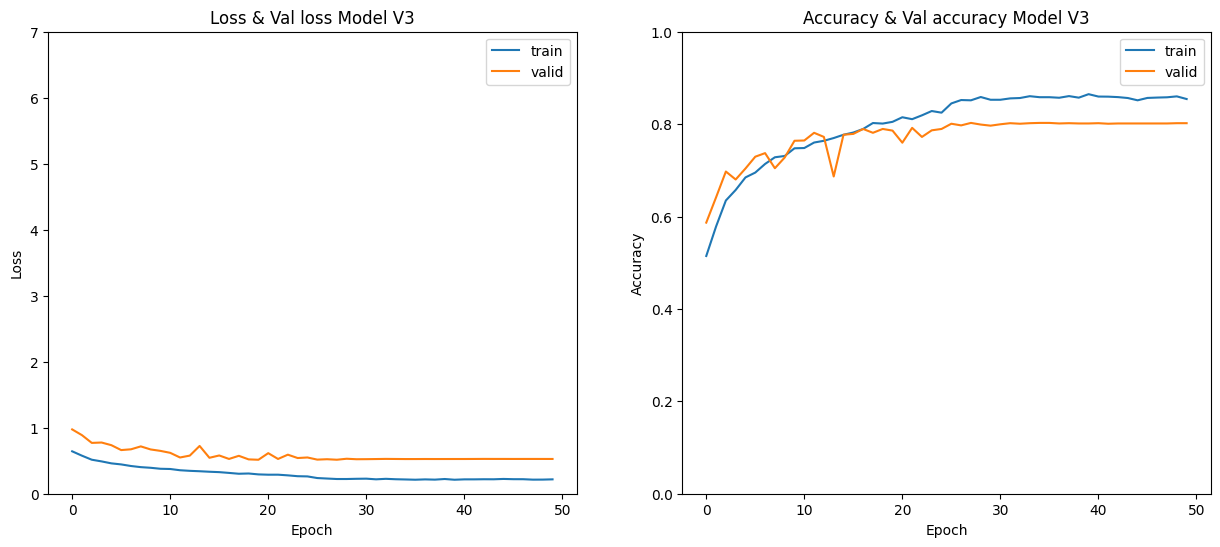

In [ ]:
plt.figure(figsize=(15,6))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 7.0])
plt.title("Loss & Val loss Model V3")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V3")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

53/53 [==============================] - 0s 3ms/step


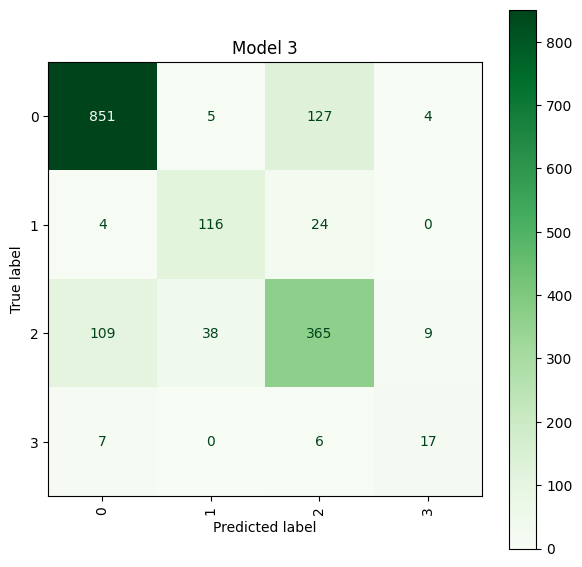

In [ ]:
y_pred = net_v3.predict(X_val_std)

decoded_value_val = np.argmax(y_val, axis = 1)
decoded_value_pred = np.argmax(y_pred, axis = 1)

conf = confusion_matrix(decoded_value_val, decoded_value_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['0', '1', '2', '3'])
fig, ax = plt.subplots(figsize=(7, 7))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='Greens')

plt.title('Model 3')
plt.show()

We already have good accuracies. In the meanwhile we reduced overfitting and fluctuations.

In [ ]:
file_modelV3 = "/content/drive/MyDrive/Saved_Models/modelV3.h5"
tf.keras.models.save_model(net_v3, file_modelV3)

### **V4 Model**: Hyperparameters tuning

We try tuning the hyperparameters of Conv1Ds: we keep a high number of filters (128) fixed, and decrease the kernel size gradually.

In [ ]:
inputs = keras.Input((TIME_STEPS, NUM_FEATURES))

x = inputs

# 1st Conv layer
x = keras.layers.Conv1D(128, 50)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(10)(x)
x = keras.layers.Dropout(0.2)(x)

# 2st Conv layer
x = keras.layers.Conv1D(128, 20)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.2)(x)

# 3st Conv layer
x = keras.layers.Conv1D(128, 10)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.2)(x)

# 4nd Conv layer
x = keras.layers.Conv1D(128, 5)(x)
x = keras.layers.Activation('relu')(x)



x = keras.layers.GlobalMaxPooling1D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(64, activation="relu", kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net_v4 = keras.Model(inputs, outputs)

# SUMMARY
net_v4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 9000, 1)]         0         
                                                                 
 conv1d_11 (Conv1D)          (None, 8951, 128)         6528      
                                                                 
 activation_11 (Activation)  (None, 8951, 128)         0         
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 895, 128)         0         
 g1D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 895, 128)          0         
                                                                 
 conv1d_12 (Conv1D)          (None, 876, 128)          327808    
                                                           

In [ ]:
net_v4.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
callback = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                             patience=5,
                                             min_lr=0.000001)

start = datetime.datetime.now()

history = net_v4.fit(X_train_std, y_train,
                          validation_data=(X_val_std, y_val),
                          epochs=50,
                          callbacks=[callback],
                          class_weight = weight_dict)

end = datetime.datetime.now()
print("Total execution time is: ", end-start)

Epoch 1/50
158/158 [==============================] - 12s 49ms/step - loss: 0.6093 - accuracy: 0.5508 - auc_3: 0.8225 - precision_3: 0.6468 - recall_3: 0.2323 - val_loss: 1.0896 - val_accuracy: 0.5428 - val_auc_3: 0.7875 - val_precision_3: 0.9634 - val_recall_3: 0.0470 - lr: 0.0010
Epoch 2/50
158/158 [==============================] - 7s 42ms/step - loss: 0.5079 - accuracy: 0.6616 - auc_3: 0.8819 - precision_3: 0.7404 - recall_3: 0.4874 - val_loss: 0.8461 - val_accuracy: 0.7182 - val_auc_3: 0.8876 - val_precision_3: 0.7871 - val_recall_3: 0.4067 - lr: 0.0010
Epoch 3/50
158/158 [==============================] - 7s 44ms/step - loss: 0.4324 - accuracy: 0.7278 - auc_3: 0.9161 - precision_3: 0.7730 - recall_3: 0.6250 - val_loss: 0.6094 - val_accuracy: 0.7634 - val_auc_3: 0.9410 - val_precision_3: 0.8080 - val_recall_3: 0.6807 - lr: 0.0010
Epoch 4/50
158/158 [==============================] - 7s 42ms/step - loss: 0.3810 - accuracy: 0.7659 - auc_3: 0.9359 - precision_3: 0.8018 - recall_3: 0.

In [ ]:
evaluation_train = net_v4.evaluate(X_train_std, y_train)
evaluation_val = net_v4.evaluate(X_val_std, y_val)
print(f'Train accuracy : {evaluation_train[1] * 100:.2f}%')
print(f'Validation accuracy : {evaluation_val[1] * 100:.2f}%')

53/53 [==============================] - 1s 15ms/step - loss: 0.4906 - accuracy: 0.8543 - auc_3: 0.9624 - precision_3: 0.8571 - recall_3: 0.8484
Train accuracy : 93.68%
Validation accuracy : 85.43%


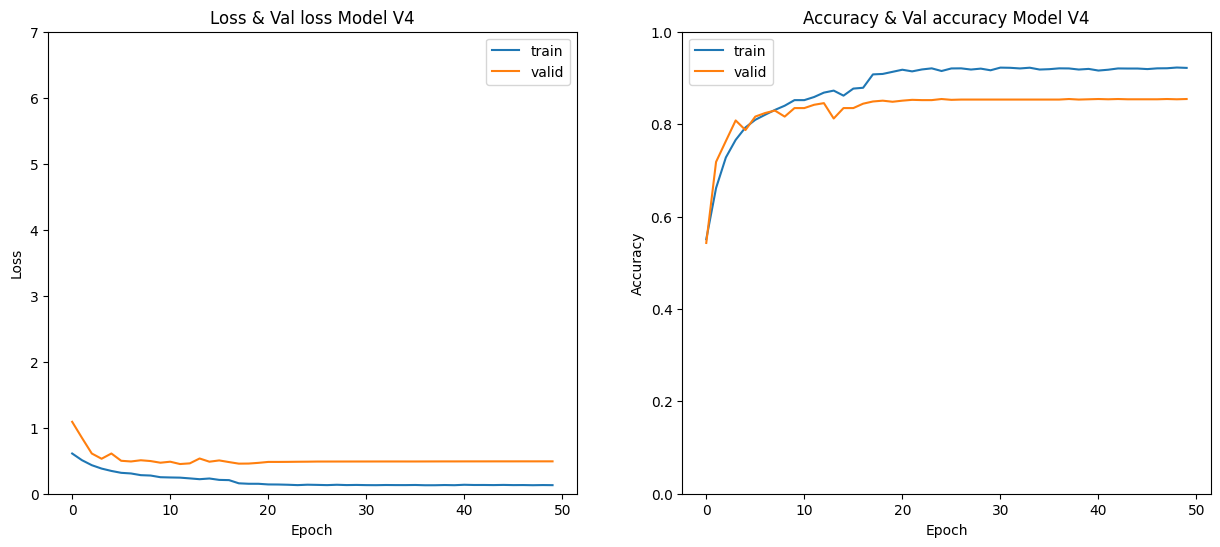

In [ ]:
plt.figure(figsize=(15,6))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 7.0])
plt.title("Loss & Val loss Model V4")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V4")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

53/53 [==============================] - 1s 12ms/step


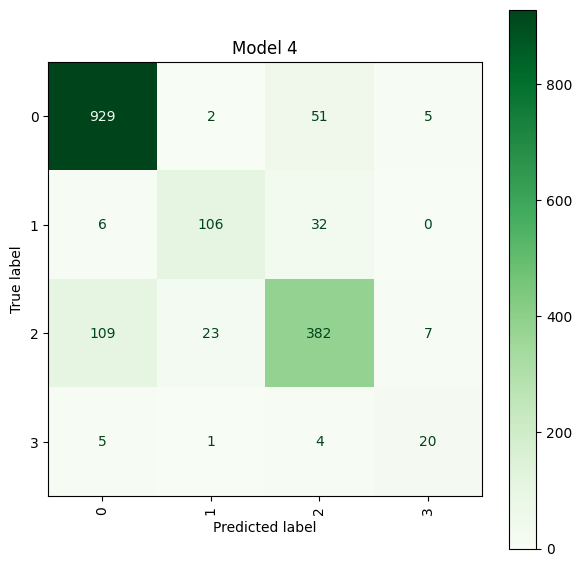

In [ ]:
y_pred = net_v4.predict(X_val_std)

decoded_value_val = np.argmax(y_val, axis = 1)
decoded_value_pred = np.argmax(y_pred, axis = 1)

conf = confusion_matrix(decoded_value_val, decoded_value_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['0', '1', '2', '3'])
fig, ax = plt.subplots(figsize=(7, 7))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='Greens')

plt.title('Model 4')
plt.show()

Accuracies have improved even further. This is already a good result.

In [ ]:
file_modelV4 = "/content/drive/MyDrive/Saved_Models/modelV4.h5"
tf.keras.models.save_model(net_v4, file_modelV4)

### **V5.a Model**: +1Dense

Let's add another dense layer with ReLU activation.
We now have three dense layers (not including softmax): let's try decreasing their output size gradually.

In [ ]:
inputs = keras.Input((TIME_STEPS, NUM_FEATURES))

x = inputs

# 1st Conv layer
x = keras.layers.Conv1D(128, 50)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(10)(x)
x = keras.layers.Dropout(0.2)(x)

# 2st Conv layer
x = keras.layers.Conv1D(128, 20)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.2)(x)

# 3st Conv layer
x = keras.layers.Conv1D(128, 10)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.2)(x)

# 4nd Conv layer
x = keras.layers.Conv1D(128, 5)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalAveragePooling1D()(x)

# Additional Dense layers
x = keras.layers.Dense(128, activation='relu', kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(64, activation='relu', kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(16, activation='relu', kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)

# Final dense layer
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net_v5a = keras.Model(inputs, outputs)

# SUMMARY
net_v5a.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 9000, 1)]         0         
                                                                 
 conv1d_15 (Conv1D)          (None, 8951, 128)         6528      
                                                                 
 activation_15 (Activation)  (None, 8951, 128)         0         
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 895, 128)         0         
 g1D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 895, 128)          0         
                                                                 
 conv1d_16 (Conv1D)          (None, 876, 128)          327808    
                                                           

In [ ]:
net_v5a.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
callback = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_lr=0.000001)

start = datetime.datetime.now()

history = net_v5a.fit(X_train_std, y_train,
                  validation_data=(X_val_std, y_val),
                  epochs=50,
                  callbacks=[callback])

end = datetime.datetime.now()
print("Total execution time is: ", end-start)

Epoch 1/50
158/158 [==============================] - 10s 45ms/step - loss: 0.9723 - accuracy: 0.5867 - auc_4: 0.8327 - precision_4: 0.6632 - recall_4: 0.4103 - val_loss: 0.8880 - val_accuracy: 0.5868 - val_auc_4: 0.8636 - val_precision_4: 0.7727 - val_recall_4: 0.4144 - lr: 0.0010
Epoch 2/50
158/158 [==============================] - 6s 40ms/step - loss: 0.8368 - accuracy: 0.6387 - auc_4: 0.8755 - precision_4: 0.7355 - recall_4: 0.5138 - val_loss: 0.7774 - val_accuracy: 0.6671 - val_auc_4: 0.8995 - val_precision_4: 0.7146 - val_recall_4: 0.6058 - lr: 0.0010
Epoch 3/50
158/158 [==============================] - 7s 45ms/step - loss: 0.6936 - accuracy: 0.7132 - auc_4: 0.9139 - precision_4: 0.7614 - recall_4: 0.6232 - val_loss: 0.6278 - val_accuracy: 0.7224 - val_auc_4: 0.9304 - val_precision_4: 0.7730 - val_recall_4: 0.6397 - lr: 0.0010
Epoch 4/50
158/158 [==============================] - 7s 44ms/step - loss: 0.6291 - accuracy: 0.7370 - auc_4: 0.9294 - precision_4: 0.7843 - recall_4: 0.

In [ ]:
evaluation_train = net_v5a.evaluate(X_train_std, y_train)
evaluation_val = net_v5a.evaluate(X_val_std, y_val)
print(f'Train accuracy : {evaluation_train[1] * 100:.2f}%')
print(f'Validation accuracy : {evaluation_val[1] * 100:.2f}%')

53/53 [==============================] - 1s 16ms/step - loss: 0.4892 - accuracy: 0.8442 - auc_4: 0.9638 - precision_4: 0.8500 - recall_4: 0.8424
Train accuracy : 91.62%
Validation accuracy : 84.42%


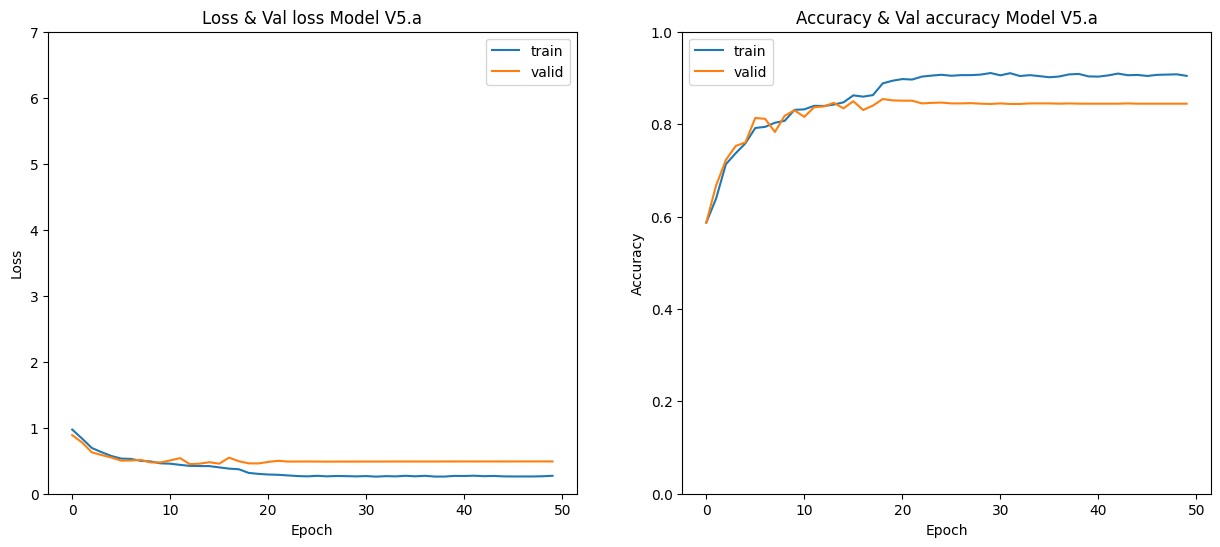

In [ ]:
plt.figure(figsize=(15,6))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 7.0])
plt.title("Loss & Val loss Model V5.a")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V5.a")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

53/53 [==============================] - 1s 12ms/step


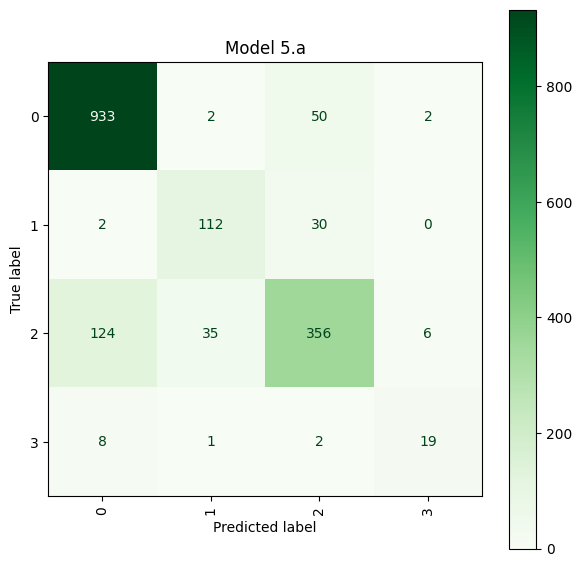

In [ ]:
y_pred = net_v5a.predict(X_val_std)

decoded_value_val = np.argmax(y_val, axis = 1)
decoded_value_pred = np.argmax(y_pred, axis = 1)

conf = confusion_matrix(decoded_value_val, decoded_value_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['0', '1', '2', '3'])
fig, ax = plt.subplots(figsize=(7, 7))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='Greens')

plt.title('Model 5.a')
plt.show()

We don't have major improvements: loss is slightly improved, while accuracy is slightly worse. Let's see if increasing complexity even further and tuning parameters leads to better performances.

In [ ]:
file_modelV5a = "/content/drive/MyDrive/Saved_Models/modelV5a.h5"
tf.keras.models.save_model(net_v5a, file_modelV5a)

### **V6 Model**: +1Conv

We add an additional convolutional layer while tuning their filters number and kernel size:

In [ ]:
inputs = keras.Input((TIME_STEPS, NUM_FEATURES))

x = inputs

# 1st Conv layer
x = keras.layers.Conv1D(128, 60)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(10)(x)
x = keras.layers.Dropout(0.2)(x)

# 2st Conv layer
x = keras.layers.Conv1D(128, 30)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.2)(x)

# 3st Conv layer
x = keras.layers.Conv1D(128, 15)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.2)(x)

# 4nd Conv layer
x = keras.layers.Conv1D(128, 5)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.2)(x)

# 5nd Conv layer
x = keras.layers.Conv1D(128, 2)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalAveragePooling1D()(x)

# Additional Dense layers
x = keras.layers.Dense(128, activation='relu', kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(64, activation='relu', kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(16, activation='relu', kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)

# Final dense layer
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net_v6 = keras.Model(inputs, outputs)

# SUMMARY
net_v6.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 9000, 1)]         0         
                                                                 
 conv1d_19 (Conv1D)          (None, 8941, 128)         7808      
                                                                 
 activation_19 (Activation)  (None, 8941, 128)         0         
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 894, 128)         0         
 g1D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 894, 128)          0         
                                                                 
 conv1d_20 (Conv1D)          (None, 865, 128)          491648    
                                                           

In [ ]:
net_v6.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
callback = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_lr=0.000001)

start = datetime.datetime.now()

history = net_v6.fit(X_train_std, y_train,
                  validation_data=(X_val_std, y_val),
                  epochs=50,
                  callbacks=[callback])

end = datetime.datetime.now()
print("Total execution time is: ", end-start)

Epoch 1/50
158/158 [==============================] - 13s 54ms/step - loss: 1.0194 - accuracy: 0.5473 - auc_5: 0.8182 - precision_5: 0.6502 - recall_5: 0.3514 - val_loss: 0.8545 - val_accuracy: 0.5868 - val_auc_5: 0.8683 - val_precision_5: 0.7284 - val_recall_5: 0.4958 - lr: 0.0010
Epoch 2/50
158/158 [==============================] - 7s 47ms/step - loss: 0.8027 - accuracy: 0.6599 - auc_5: 0.8850 - precision_5: 0.7513 - recall_5: 0.5372 - val_loss: 0.6815 - val_accuracy: 0.7224 - val_auc_5: 0.9168 - val_precision_5: 0.7755 - val_recall_5: 0.6510 - lr: 0.0010
Epoch 3/50
158/158 [==============================] - 7s 45ms/step - loss: 0.6864 - accuracy: 0.7278 - auc_5: 0.9174 - precision_5: 0.7864 - recall_5: 0.6398 - val_loss: 0.6292 - val_accuracy: 0.7527 - val_auc_5: 0.9329 - val_precision_5: 0.8065 - val_recall_5: 0.6665 - lr: 0.0010
Epoch 4/50
158/158 [==============================] - 8s 48ms/step - loss: 0.6382 - accuracy: 0.7510 - auc_5: 0.9283 - precision_5: 0.8020 - recall_5: 0.

In [ ]:
evaluation_train = net_v6.evaluate(X_train_std, y_train)
evaluation_val = net_v6.evaluate(X_val_std, y_val)
print(f'Train accuracy : {evaluation_train[1] * 100:.2f}%')
print(f'Validation accuracy : {evaluation_val[1] * 100:.2f}%')

53/53 [==============================] - 1s 15ms/step - loss: 0.5415 - accuracy: 0.8419 - auc_5: 0.9583 - precision_5: 0.8466 - recall_5: 0.8365
Train accuracy : 93.06%
Validation accuracy : 84.19%


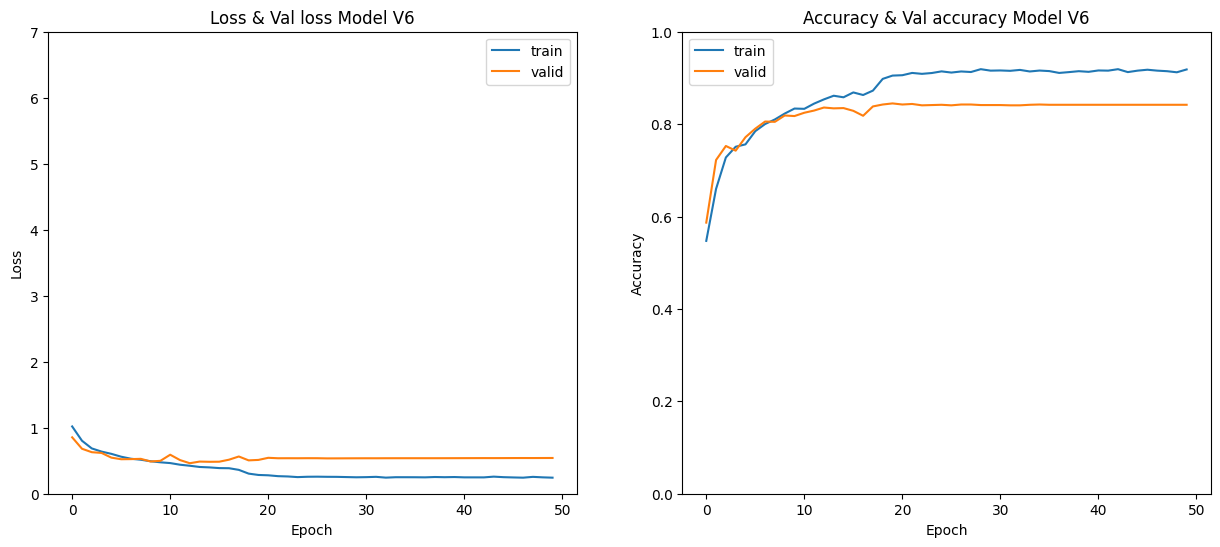

In [ ]:
plt.figure(figsize=(15,6))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 7.0])
plt.title("Loss & Val loss Model V6")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V6")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

53/53 [==============================] - 1s 12ms/step


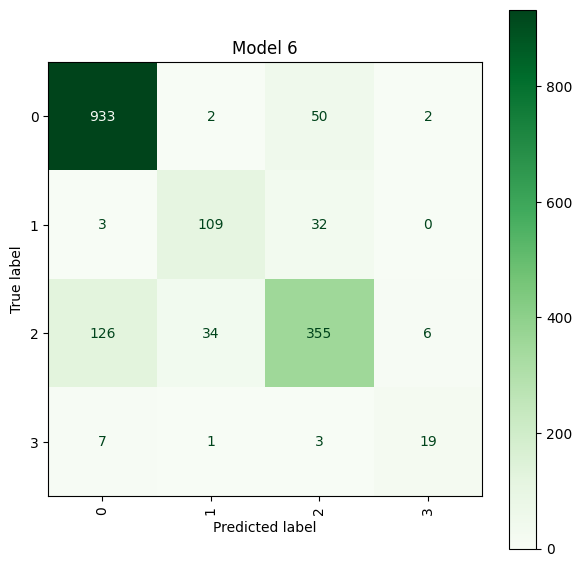

In [ ]:
y_pred = net_v6.predict(X_val_std)

decoded_value_val = np.argmax(y_val, axis = 1)
decoded_value_pred = np.argmax(y_pred, axis = 1)

conf = confusion_matrix(decoded_value_val, decoded_value_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['0', '1', '2', '3'])
fig, ax = plt.subplots(figsize=(7, 7))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='Greens')

plt.title('Model 6')
plt.show()

Performance of V6 is slightly worse than V5.a in all metrics.
Let's go back to V5.a and try other alternatives to increase complexity.

In [ ]:
file_modelV6 = "/content/drive/MyDrive/Saved_Models/modelV6.h5"
tf.keras.models.save_model(net_v6, file_modelV6)

### **V5.b Model**: + LSTM

We replace the final dense layers of the V5.a model with two LSTM layers, with decreasing output dimensionality. After CNN captured spatial dependencies, our goal was to capture amplitude-temporal dependencies using LSTM layers, which is a type of RNN that have the ability to remember past inputs and forget irrelevant information selectively. We also managed to reduce dropout rates to 10% without causing overfitting.


The two LSTM layers have a different value for the `return_sequences` argument: the first one is set to True, which means that the layer outputs an array with all the intermediate hidden states of each timestep. This is necessary to concatenate the second LSTM layer, which has `return_sequences=False`, meaning it will only output the hidden state of the last timestep. This means that the last layer will return a 1-Dimensional output, which is the dimensionality expected from the output layer, and therefore we can drop the `GlobalMaxPooling1D` layer, that we previously used for the same purpose.

In [ ]:
inputs = keras.Input((TIME_STEPS, NUM_FEATURES))

x = inputs

# 1st Conv layer
x = keras.layers.Conv1D(128, 55)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(10)(x)
x = keras.layers.Dropout(0.1)(x)

# 2st Conv layer
x = keras.layers.Conv1D(128, 25)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.1)(x)

# 3st Conv layer
x = keras.layers.Conv1D(128, 10)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.1)(x)

# 4nd Conv layer
x = keras.layers.Conv1D(128, 5)(x)
x = keras.layers.Activation('relu')(x)

# 1st and 2st LSTM Layers
x = keras.layers.LSTM(128, return_sequences=True)(x)
x = keras.layers.Activation('tanh')(x)

x = keras.layers.LSTM(64, return_sequences=False)(x)
x = keras.layers.Activation('tanh')(x)

# Final dense layer
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net_v5b = keras.Model(inputs, outputs)

# SUMMARY
net_v5b.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 9000, 1)]         0         
                                                                 
 conv1d_24 (Conv1D)          (None, 8946, 128)         7168      
                                                                 
 activation_24 (Activation)  (None, 8946, 128)         0         
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 894, 128)         0         
 g1D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 894, 128)          0         
                                                                 
 conv1d_25 (Conv1D)          (None, 870, 128)          409728    
                                                           

In [ ]:
net_v5b.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])


In [ ]:
callback = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_lr=0.000001)

start = datetime.datetime.now()

history = net_v5b.fit(X_train_std, y_train,
                  validation_data=(X_val_std, y_val),
                  epochs=50,
                  callbacks=[callback])

end = datetime.datetime.now()
print("Total execution time is: ", end-start)

Epoch 1/50
158/158 [==============================] - 19s 66ms/step - loss: 0.9699 - accuracy: 0.5841 - auc_6: 0.8207 - precision_6: 0.5867 - recall_6: 0.5701 - val_loss: 0.9660 - val_accuracy: 0.5868 - val_auc_6: 0.8296 - val_precision_6: 0.5868 - val_recall_6: 0.5868 - lr: 0.0010
Epoch 2/50
158/158 [==============================] - 8s 50ms/step - loss: 0.9427 - accuracy: 0.5929 - auc_6: 0.8366 - precision_6: 0.6087 - recall_6: 0.5520 - val_loss: 0.8659 - val_accuracy: 0.6326 - val_auc_6: 0.8705 - val_precision_6: 0.6972 - val_recall_6: 0.5065 - lr: 0.0010
Epoch 3/50
158/158 [==============================] - 8s 51ms/step - loss: 0.7826 - accuracy: 0.6807 - auc_6: 0.8927 - precision_6: 0.7242 - recall_6: 0.5943 - val_loss: 0.7031 - val_accuracy: 0.7081 - val_auc_6: 0.9133 - val_precision_6: 0.7330 - val_recall_6: 0.6807 - lr: 0.0010
Epoch 4/50
158/158 [==============================] - 8s 52ms/step - loss: 0.6543 - accuracy: 0.7342 - auc_6: 0.9237 - precision_6: 0.7547 - recall_6: 0.

In [ ]:
evaluation_train = net_v5b.evaluate(X_train_std, y_train)
evaluation_val = net_v5b.evaluate(X_val_std, y_val)

print(f'Train accuracy : {evaluation_train[1] * 100:.2f}%')
print(f'Validation accuracy : {evaluation_val[1] * 100:.2f}%')

53/53 [==============================] - 1s 16ms/step - loss: 0.4497 - accuracy: 0.8633 - auc_6: 0.9648 - precision_6: 0.8646 - recall_6: 0.8615
Train accuracy : 95.50%
Validation accuracy : 86.33%


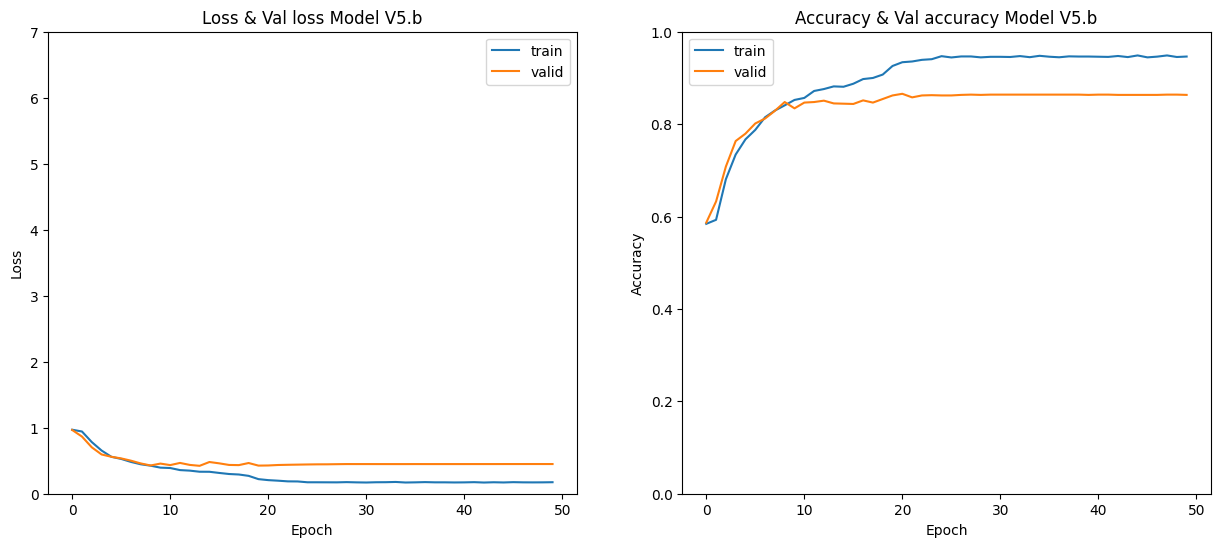

In [ ]:
plt.figure(figsize=(15,6))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 7.0])
plt.title("Loss & Val loss Model V5.b")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V5.b")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])


53/53 [==============================] - 1s 14ms/step


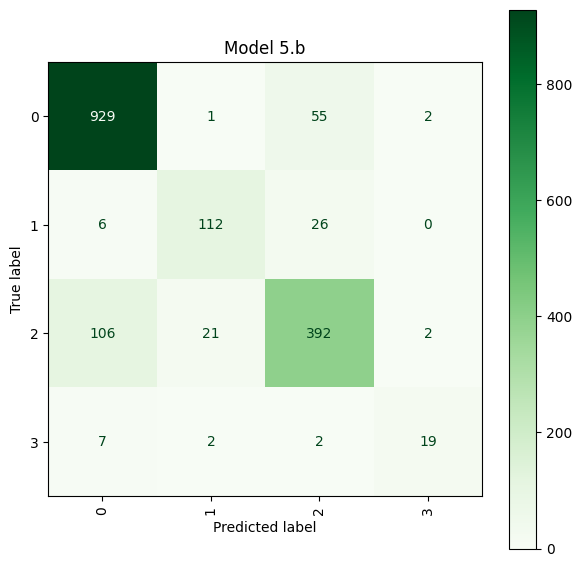

In [ ]:
y_pred = net_v5b.predict(X_val_std)

decoded_value_val = np.argmax(y_val, axis = 1)
decoded_value_pred = np.argmax(y_pred, axis = 1)

conf = confusion_matrix(decoded_value_val, decoded_value_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['0', '1', '2', '3'])
fig, ax = plt.subplots(figsize=(7, 7))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='Greens')

plt.title('Model 5.b')
plt.show()

This model has the best performance out of all the models.

The performance improvement, however, is very little, so it seems like we reached a point of model convergence. So we stop here, selecting V5.b as the best model for the weighted loss approach.

In [ ]:
file_modelV5b = "/content/drive/MyDrive/Saved_Models/modelV5b.h5"
tf.keras.models.save_model(net_v5b, file_modelV5b)

## **Data Augmentation**

Now that we have obtained good models in terms of accuracy, let's try the data augmentation approach instead of the weighted loss approach to see if it improves the classification.

As already observed, the four classes have very unbalanced values among them, respectively 2962, 431, 1562 and 90 elements. We therefore want to balance classes by bringing them all to 2962 components (size of the majority class).

Several approaches to data augmentation of ECG signals are used in literature, such as:
* *Rotation*: shifting the elements of the array by a certain number of positions;
* *Flipping*: flipping the signal either on the horizontal or vertical axis;
* *Jittering*: adding a small random constant (noise) among all the observations.

To avoid altering the nature of the signals by reading them backwards, upside down or by splitting the signal in random points, we decided to only use **jittering** on our data, adding a constant distributed like a standard Normal curve.

So we applied jittering with a scale factor of 1, which is the standard deviation of the distribution from which we generate the noise values.

In [ ]:
def DA_Jitter(X, sigma = 1):
  myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
  return X+myNoise

In [ ]:
def augmenting_data(X_train, y_train):
  num_classes = y_train.shape[1]
  class_counts = np.sum(y_train, axis=0)
  max_count = np.max(class_counts)
  new_X_train = []
  new_y_train = []

  for class_label in range(num_classes):
    indices = np.where(y_train[:, class_label] == 1)[0]
    num_samples = len(indices)
    num_jittered_samples = max_count - num_samples

    if num_jittered_samples > 0:
      cyclic_indices = itertools.cycle(list(indices))
      jittered_indices = list(itertools.islice(cyclic_indices, math.floor(num_jittered_samples)))

      jittered_X = []
      for n in jittered_indices:
        jittered_n = DA_Jitter(X_train[n])
        jittered_X.append(jittered_n)

      jittered_y = np.zeros((int(num_jittered_samples), num_classes))
      jittered_y[:, class_label] = 1

      new_X_train.append(jittered_X)
      new_y_train.append(jittered_y)

  if len(new_X_train) > 0:
    new_X_train = np.vstack(new_X_train)
    new_y_train = np.vstack(new_y_train)
    X_train = np.vstack((X_train, new_X_train))
    y_train = np.vstack((y_train, new_y_train))

  return X_train, y_train

Let's look at an example of jittering with factor = 10 (standard deviation) on a zoomed series to highlight how it works:

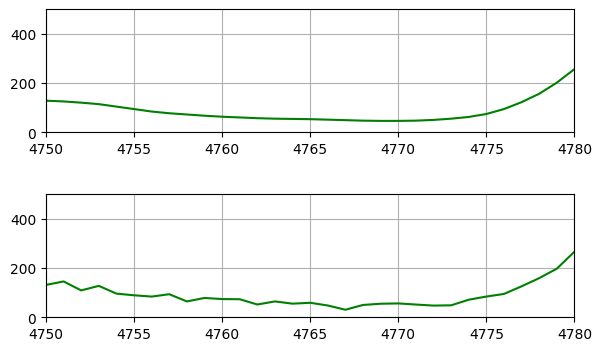

In [ ]:
fattore = 10
myX = X_train[0]

fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(2,2,1)
plt.xlim([4750, 4780])
plt.ylim([0, 500])
ax.plot(myX, color="green")
ax.grid()


ax = fig.add_subplot(2,2,3)
plt.xlim([4750, 4780])
plt.ylim([0, 500])
ax.plot(DA_Jitter(myX, fattore), color="green")
ax.grid()

plt.subplots_adjust(hspace=0.5)

As we can see by zooming-in, jittering applies very small alterations on the signal, so that we can augment data without losing their main information.

Let's apply the Jittering function we generated on our data:

In [ ]:
X_train_aug, y_train_aug = augmenting_data(X_train, y_train)

In [ ]:
(len(X_train_aug), len(y_train_aug))

(11848, 11848)

In [ ]:
grouped_stats = np.sum(y_train_aug, axis=0)

for i, count in enumerate(grouped_stats):
    print(f"Class {i}: {int(grouped_stats[i])} elements")

Class 0: 2962 elements
Class 1: 2962 elements
Class 2: 2962 elements
Class 3: 2962 elements


**Standardization** of augmented data:


In [ ]:
X_train_aug_std = scaler.fit_transform(X_train_aug)

## **Models implementation on augmented data**

Let's now train the 3 best-performing models on the augmented data:

### V4 Model on augmented data

In [ ]:
inputs = keras.Input((TIME_STEPS, NUM_FEATURES))

x = inputs

# 1st Conv layer
x = keras.layers.Conv1D(128, 50)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(10)(x)
x = keras.layers.Dropout(0.2)(x)

# 2st Conv layer
x = keras.layers.Conv1D(128, 20)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.2)(x)

# 3st Conv layer
x = keras.layers.Conv1D(128, 10)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.2)(x)

# 4nd Conv layer
x = keras.layers.Conv1D(128, 5)(x)
x = keras.layers.Activation('relu')(x)


x = keras.layers.GlobalMaxPooling1D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(64, activation="relu", kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net_aug_v4 = keras.Model(inputs, outputs)

# SUMMARY
net_aug_v4.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 9000, 1)]         0         
                                                                 
 conv1d_39 (Conv1D)          (None, 8951, 128)         6528      
                                                                 
 activation_43 (Activation)  (None, 8951, 128)         0         
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 895, 128)         0         
 g1D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 895, 128)          0         
                                                                 
 conv1d_40 (Conv1D)          (None, 876, 128)          327808    
                                                          

In [ ]:
net_aug_v4.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
callback = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                             patience=5,
                                             min_lr=0.000001)

start = datetime.datetime.now()

history = net_aug_v4.fit(X_train_aug_std, y_train_aug,
                          validation_data=(X_val_std, y_val),
                          epochs=50,
                          callbacks=[callback]
                         )

end = datetime.datetime.now()
print("Total execution time is: ", end-start)

Epoch 1/50
371/371 [==============================] - 25s 48ms/step - loss: 1.0509 - accuracy: 0.5086 - auc_10: 0.7949 - precision_10: 0.7382 - recall_10: 0.2728 - val_loss: 0.9418 - val_accuracy: 0.6118 - val_auc_10: 0.8550 - val_precision_10: 0.6858 - val_recall_10: 0.4126 - lr: 0.0010
Epoch 2/50
371/371 [==============================] - 16s 44ms/step - loss: 0.6817 - accuracy: 0.7124 - auc_10: 0.9183 - precision_10: 0.7741 - recall_10: 0.6147 - val_loss: 0.8502 - val_accuracy: 0.6926 - val_auc_10: 0.8849 - val_precision_10: 0.7092 - val_recall_10: 0.6540 - lr: 0.0010
Epoch 3/50
371/371 [==============================] - 15s 39ms/step - loss: 0.5205 - accuracy: 0.7949 - auc_10: 0.9519 - precision_10: 0.8226 - recall_10: 0.7533 - val_loss: 0.6184 - val_accuracy: 0.7937 - val_auc_10: 0.9327 - val_precision_10: 0.8030 - val_recall_10: 0.7729 - lr: 0.0010
Epoch 4/50
371/371 [==============================] - 15s 40ms/step - loss: 0.4110 - accuracy: 0.8401 - auc_10: 0.9689 - precision_10

In [ ]:
evaluation_train = net_aug_v4.evaluate(X_train_std, y_train)
evaluation_val = net_aug_v4.evaluate(X_val_std, y_val)
print(f'Train accuracy : {evaluation_train[1] * 100:.2f}%')
print(f'Validation accuracy : {evaluation_val[1] * 100:.2f}%')

53/53 [==============================] - 1s 17ms/step - loss: 0.6607 - accuracy: 0.8466 - auc_10: 0.9525 - precision_10: 0.8479 - recall_10: 0.8454
Train accuracy : 92.29%
Validation accuracy : 84.66%


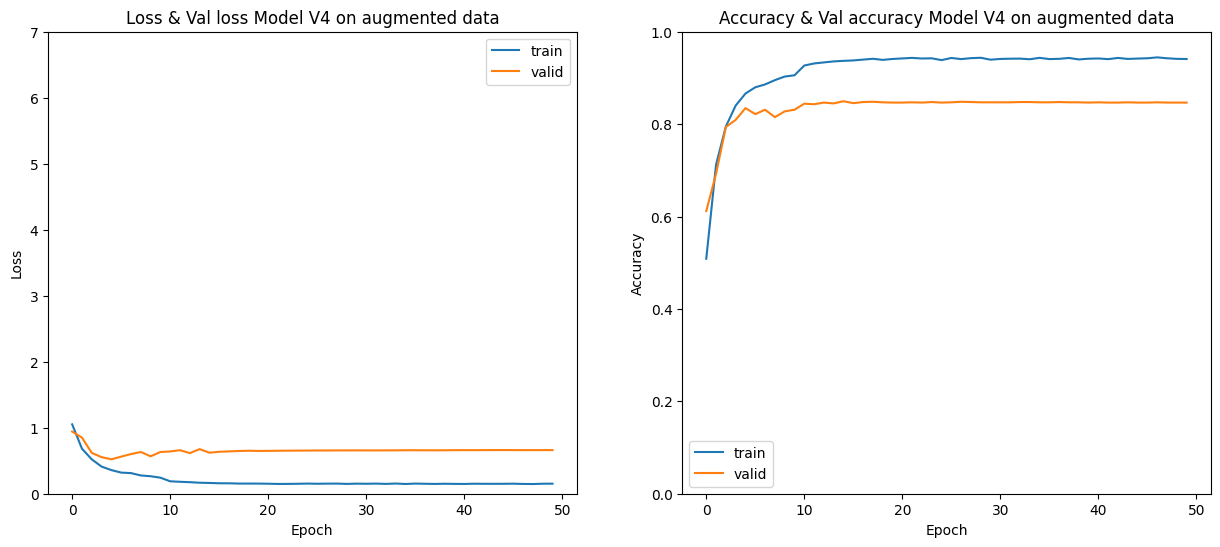

In [ ]:
plt.figure(figsize=(15,6))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 7.0])
plt.title("Loss & Val loss Model V4 on augmented data")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V4 on augmented data")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

53/53 [==============================] - 1s 13ms/step


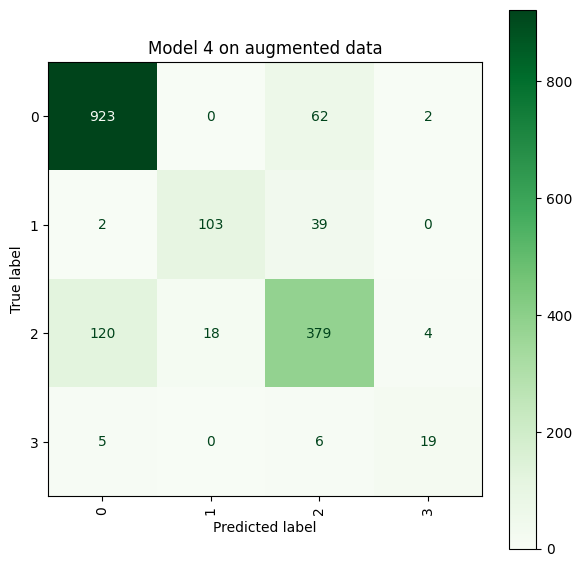

In [ ]:
y_pred = net_aug_v4.predict(X_val_std)

decoded_value_val = np.argmax(y_val, axis = 1)
decoded_value_pred = np.argmax(y_pred, axis = 1)

conf = confusion_matrix(decoded_value_val, decoded_value_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['0', '1', '2', '3'])
fig, ax = plt.subplots(figsize=(7, 7))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='Greens')

plt.title('Model 4 on augmented data')
plt.show()

This model performs slightly worse on all metrics with respect to its weighted loss alternative.

In [ ]:
file_modelV4_aug = "/content/drive/MyDrive/Saved_Models/modelV4_aug.h5"
tf.keras.models.save_model(net_aug_v4, file_modelV4_aug)

### V5.a Model on augmented data

In [ ]:
# Architecture definition
inputs = keras.Input((TIME_STEPS, NUM_FEATURES))

x = inputs

# 1st Conv layer
x = keras.layers.Conv1D(128, 50)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(10)(x)
x = keras.layers.Dropout(0.2)(x)

# 2st Conv layer
x = keras.layers.Conv1D(128, 20)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.2)(x)

# 3st Conv layer
x = keras.layers.Conv1D(128, 10)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.2)(x)

# 4nd Conv layer
x = keras.layers.Conv1D(128, 5)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalAveragePooling1D()(x)

# Additional Dense layers
x = keras.layers.Dense(128, activation='relu', kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(64, activation='relu', kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(16, activation='relu', kernel_initializer='normal')(x)
x = keras.layers.Dropout(0.2)(x)

# Final dense layer
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net_aug_v5a = keras.Model(inputs, outputs)

# SUMMARY
net_aug_v5a.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 9000, 1)]         0         
                                                                 
 conv1d_28 (Conv1D)          (None, 8951, 128)         6528      
                                                                 
 activation_30 (Activation)  (None, 8951, 128)         0         
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 895, 128)         0         
 g1D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 895, 128)          0         
                                                                 
 conv1d_29 (Conv1D)          (None, 876, 128)          327808    
                                                           

In [ ]:
net_aug_v5a.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
callback = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_lr=0.000001)

start = datetime.datetime.now()

history = net_aug_v5a.fit(X_train_aug_std, y_train_aug,
                          validation_data=(X_val_std, y_val),
                          epochs=50,
                          callbacks=[callback])

end = datetime.datetime.now()
print("Total execution time is: ", end-start)

Epoch 1/50
371/371 [==============================] - 19s 41ms/step - loss: 1.1365 - accuracy: 0.4206 - auc_7: 0.7341 - precision_7: 0.8236 - recall_7: 0.1635 - val_loss: 1.3272 - val_accuracy: 0.5077 - val_auc_7: 0.6999 - val_precision_7: 0.1849 - val_recall_7: 0.0161 - lr: 0.0010
Epoch 2/50
371/371 [==============================] - 15s 40ms/step - loss: 0.8421 - accuracy: 0.6013 - auc_7: 0.8664 - precision_7: 0.7884 - recall_7: 0.3824 - val_loss: 0.7501 - val_accuracy: 0.6570 - val_auc_7: 0.8981 - val_precision_7: 0.6936 - val_recall_7: 0.5868 - lr: 0.0010
Epoch 3/50
371/371 [==============================] - 15s 40ms/step - loss: 0.6838 - accuracy: 0.7007 - auc_7: 0.9151 - precision_7: 0.7626 - recall_7: 0.5966 - val_loss: 0.7450 - val_accuracy: 0.6926 - val_auc_7: 0.9065 - val_precision_7: 0.7381 - val_recall_7: 0.6385 - lr: 0.0010
Epoch 4/50
371/371 [==============================] - 15s 40ms/step - loss: 0.5596 - accuracy: 0.7719 - auc_7: 0.9436 - precision_7: 0.8086 - recall_7:

In [ ]:
evaluation_train = net_aug_v5a.evaluate(X_train_aug_std, y_train_aug)
evaluation_val = net_aug_v5a.evaluate(X_val_std, y_val)
print(f'Train accuracy : {evaluation_train[1] * 100:.2f}%')
print(f'Validation accuracy : {evaluation_val[1] * 100:.2f}%')

53/53 [==============================] - 1s 15ms/step - loss: 0.6479 - accuracy: 0.8436 - auc_7: 0.9522 - precision_7: 0.8451 - recall_7: 0.8430
Train accuracy : 93.93%
Validation accuracy : 84.36%


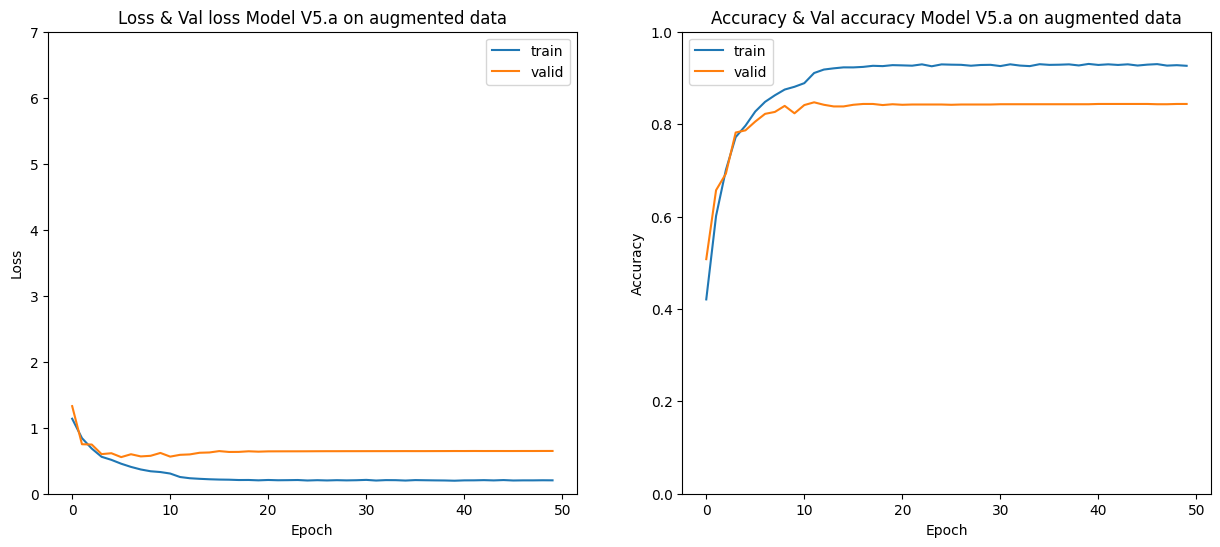

In [ ]:
plt.figure(figsize=(15,6))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 7.0])
plt.title("Loss & Val loss Model V5.a on augmented data")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V5.a on augmented data")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

53/53 [==============================] - 1s 12ms/step


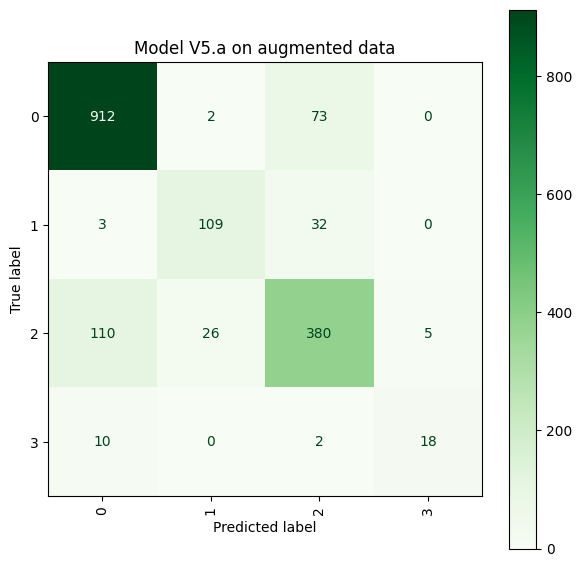

In [ ]:
y_pred = net_aug_v5a.predict(X_val_std)

decoded_value_val = np.argmax(y_val, axis = 1)
decoded_value_pred = np.argmax(y_pred, axis = 1)

conf = confusion_matrix(decoded_value_val, decoded_value_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['0', '1', '2', '3'])
fig, ax = plt.subplots(figsize=(7, 7))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='Greens')

plt.title('Model V5.a on augmented data')
plt.show()

This model performs slightly worse on almost all metrics with respect to its weighted loss alternative.

In [ ]:
file_modelV5a_aug = "/content/drive/MyDrive/Saved_Models/modelV5a_aug.h5"
tf.keras.models.save_model(net_aug_v5a, file_modelV5a_aug)

### V5.b Model on augmented data

In [ ]:
inputs = keras.Input((TIME_STEPS, NUM_FEATURES))

x = inputs

# 1st Conv layer
x = keras.layers.Conv1D(128, 55)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(10)(x)
x = keras.layers.Dropout(0.1)(x)

# 2st Conv layer
x = keras.layers.Conv1D(128, 25)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.1)(x)

# 3st Conv layer
x = keras.layers.Conv1D(128, 10)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Dropout(0.1)(x)

# 4nd Conv layer
x = keras.layers.Conv1D(128, 5)(x)
x = keras.layers.Activation('relu')(x)

# 1st and 2st LSTM Layers
x = keras.layers.LSTM(128, return_sequences=True)(x)
x = keras.layers.Activation('tanh')(x)

x = keras.layers.LSTM(64, return_sequences=False)(x)
x = keras.layers.Activation('tanh')(x)

# Final dense layer
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net_aug_v5b = keras.Model(inputs, outputs)

# SUMMARY
net_aug_v5b.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 9000, 1)]         0         
                                                                 
 conv1d_32 (Conv1D)          (None, 8946, 128)         7168      
                                                                 
 activation_34 (Activation)  (None, 8946, 128)         0         
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 894, 128)         0         
 g1D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 894, 128)          0         
                                                                 
 conv1d_33 (Conv1D)          (None, 870, 128)          409728    
                                                           

In [ ]:
net_aug_v5b.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer= keras.optimizers.Adam(learning_rate=0.001),
                    metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])


In [ ]:
callback = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_lr=0.000001)

start = datetime.datetime.now()

history = net_aug_v5b.fit(X_train_aug_std, y_train_aug,
                  validation_data=(X_val_std, y_val),
                  epochs=50,
                  callbacks=[callback])

end = datetime.datetime.now()
print("Total execution time is: ", end-start)

Epoch 1/50
371/371 [==============================] - 24s 49ms/step - loss: 0.8908 - accuracy: 0.5782 - auc_8: 0.8506 - precision_8: 0.7387 - recall_8: 0.4240 - val_loss: 0.7752 - val_accuracy: 0.6766 - val_auc_8: 0.8854 - val_precision_8: 0.7155 - val_recall_8: 0.5725 - lr: 0.0010
Epoch 2/50
371/371 [==============================] - 17s 45ms/step - loss: 0.5679 - accuracy: 0.7654 - auc_8: 0.9408 - precision_8: 0.7915 - recall_8: 0.7335 - val_loss: 0.6240 - val_accuracy: 0.7473 - val_auc_8: 0.9258 - val_precision_8: 0.7604 - val_recall_8: 0.7247 - lr: 0.0010
Epoch 3/50
371/371 [==============================] - 17s 45ms/step - loss: 0.4395 - accuracy: 0.8281 - auc_8: 0.9640 - precision_8: 0.8399 - recall_8: 0.8134 - val_loss: 0.5278 - val_accuracy: 0.8020 - val_auc_8: 0.9463 - val_precision_8: 0.8076 - val_recall_8: 0.7883 - lr: 0.0010
Epoch 4/50
371/371 [==============================] - 16s 44ms/step - loss: 0.3768 - accuracy: 0.8517 - auc_8: 0.9734 - precision_8: 0.8610 - recall_8:

In [ ]:
evaluation_train = net_aug_v5b.evaluate(X_train_aug_std, y_train_aug)
evaluation_val = net_aug_v5b.evaluate(X_val_std, y_val)

print(f'Train accuracy : {evaluation_train[1] * 100:.2f}%')
print(f'Validation accuracy : {evaluation_val[1] * 100:.2f}%')

53/53 [==============================] - 1s 17ms/step - loss: 0.5991 - accuracy: 0.8347 - auc_8: 0.9478 - precision_8: 0.8376 - recall_8: 0.8341
Train accuracy : 97.48%
Validation accuracy : 83.47%


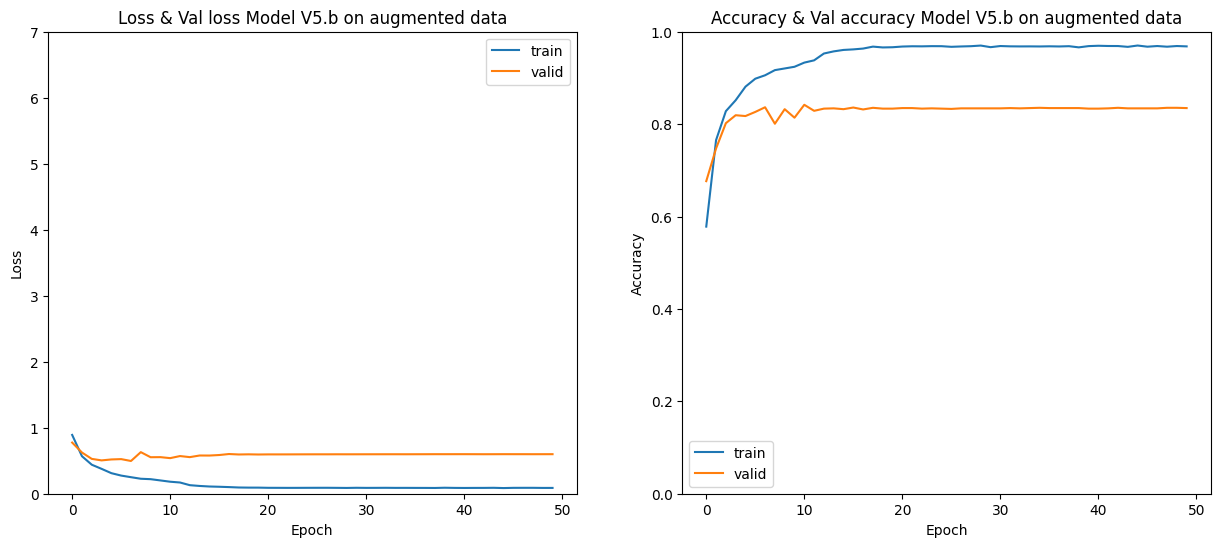

In [ ]:
plt.figure(figsize=(15,6))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 7.0])
plt.title("Loss & Val loss Model V5.b on augmented data")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V5.b on augmented data")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])


53/53 [==============================] - 1s 15ms/step


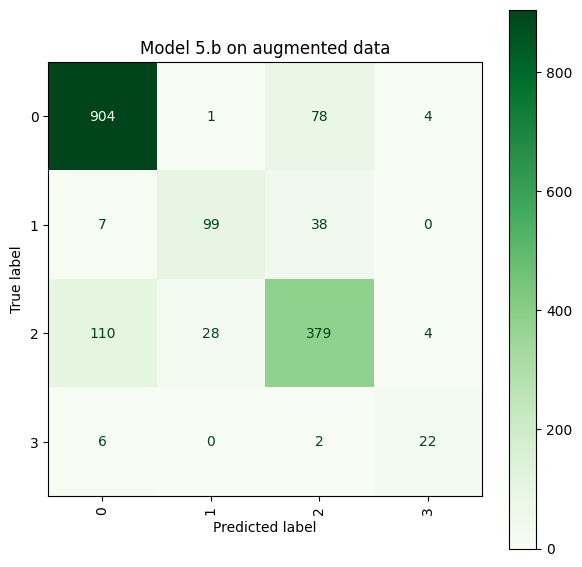

In [ ]:
y_pred = net_aug_v5b.predict(X_val_std)

decoded_value_val = np.argmax(y_val, axis = 1)
decoded_value_pred = np.argmax(y_pred, axis = 1)

conf = confusion_matrix(decoded_value_val, decoded_value_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['0', '1', '2', '3'])
fig, ax = plt.subplots(figsize=(7, 7))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='Greens')

plt.title('Model 5.b on augmented data')
plt.show()

This model also performs slightly worse with respect to its weighted loss alternative. Also, we observe some overfitting on the training set curve.

In [ ]:
file_modelV5b_aug = "/content/drive/MyDrive/Saved_Models/modelV5b_aug.h5"
tf.keras.models.save_model(net_aug_v5b, file_modelV5b_aug)

## Best model selection + Test set evaluation

Taking all the metrics into consideration, the best model turned out to be V5.b applied on the NOT augmented data, making use of different weights for each class in the training phase.

In this way we obtain the highest performance, while using a safe approach that doesn't alter data.

We apply the selected model to the test set data and evaluate the results:

In [ ]:
best_model = tf.keras.models.load_model("/content/drive/MyDrive/Saved_Models/modelV5b.h5")

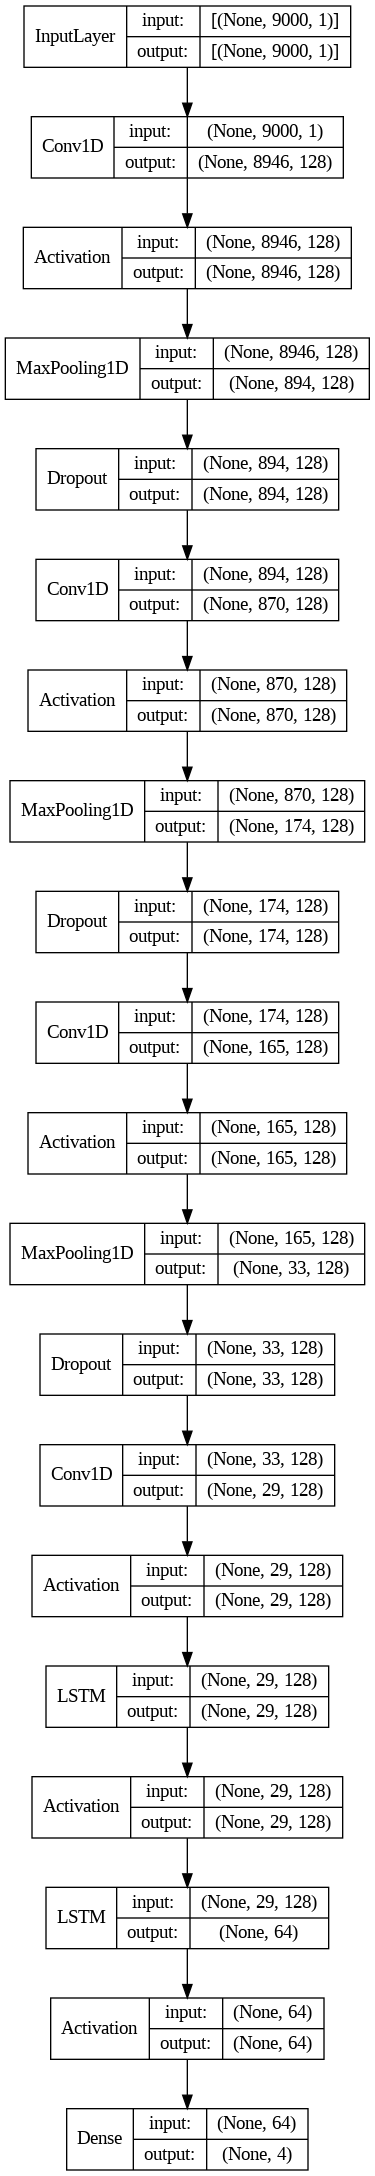

In [ ]:
tf.keras.utils.plot_model(best_model, show_shapes = True, show_layer_names=False)

Let's see the metrics on the test set:

In [ ]:
evaluation_test = best_model.evaluate(X_test_std, y_test)
print(f'Test accuracy : {evaluation_test[1] * 100:.2f}%')

53/53 [==============================] - 3s 19ms/step - loss: 0.4685 - accuracy: 0.8549 - auc_6: 0.9626 - precision_6: 0.8603 - recall_6: 0.8532
Test accuracy : 85.49%


53/53 [==============================] - 1s 15ms/step


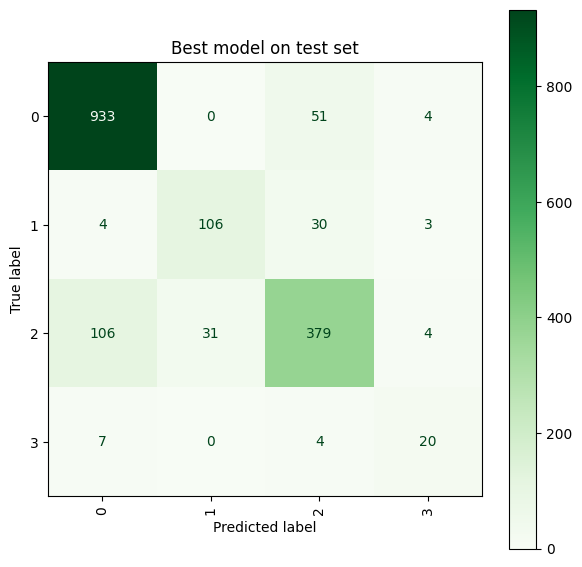

In [ ]:
y_pred_test = best_model.predict(X_test_std)

decoded_value_test = np.argmax(y_test, axis = 1)
decoded_value_pred = np.argmax(y_pred_test, axis = 1)

conf = confusion_matrix(decoded_value_test, decoded_value_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['0', '1', '2', '3'])
fig, ax = plt.subplots(figsize=(7, 7))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='Greens')

plt.title('Best model on test set')
plt.show()

In [ ]:
print(classification_report(decoded_value_test, decoded_value_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       988
           1       0.77      0.74      0.76       143
           2       0.82      0.73      0.77       520
           3       0.65      0.65      0.65        31

    accuracy                           0.85      1682
   macro avg       0.78      0.76      0.77      1682
weighted avg       0.85      0.85      0.85      1682



Let's see some examples of misclassified observations. We start by finding misclassified examples for every class:

In [ ]:
decoded_value_test, decoded_value_pred

(array([2, 3, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [ ]:
elementi_da_cercare = np.array([0,1,2,3])

lista_0 = []
lista_1 = []
lista_2 = []
lista_3 = []

for i in range(len(decoded_value_test)):

  if decoded_value_test[i] != decoded_value_pred[i]:
    if decoded_value_test[i] == 0:
      lista_0.append(i)
    elif decoded_value_test[i] == 1:
      lista_1.append(i)
    elif decoded_value_test[i] == 2:
      lista_2.append(i)
    else:
      lista_3.append(i)

Let's visualize the misclassified labels:

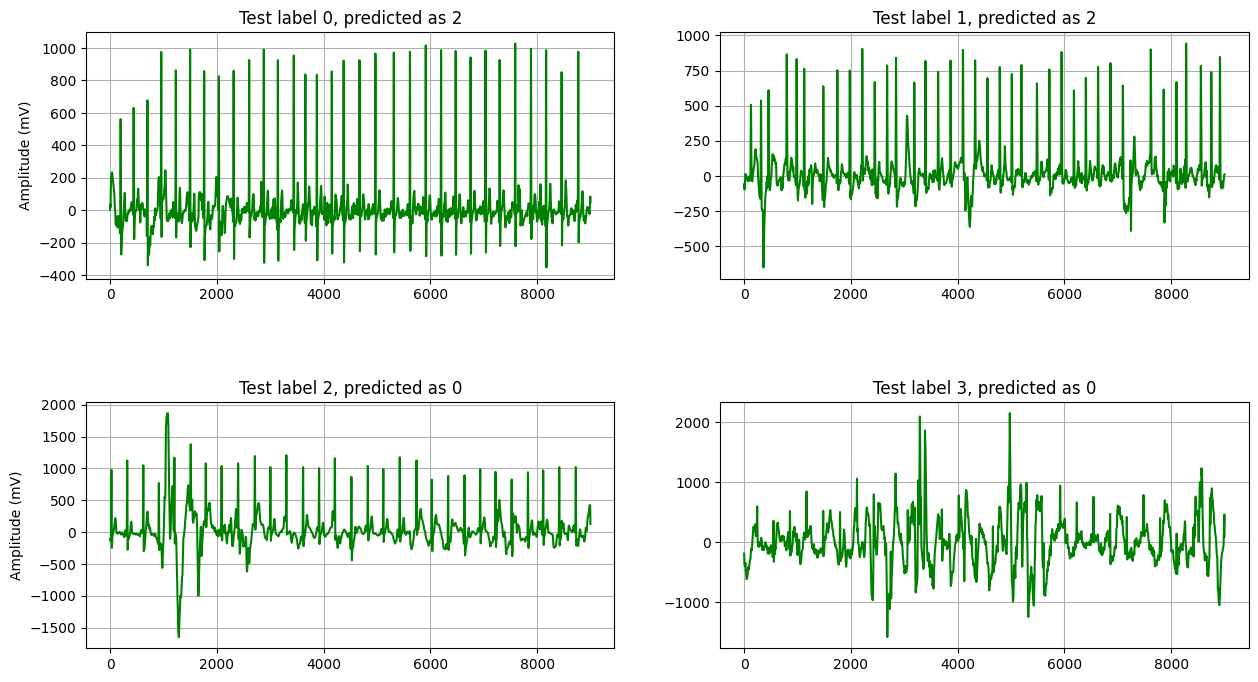

In [ ]:
plt.figure(figsize=(15,8))

# classe 0

plt.subplot(2, 2, 1)
plt.plot(X_test[lista_0[0]], color="green")
plt.title(f'Test label 0, predicted as {decoded_value_pred[lista_0[0]]}')
plt.ylabel('Amplitude (mV)')
plt.grid()

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.2)

# classe 1

plt.subplot(2, 2, 2)
plt.plot(X_test[lista_1[0]], color="green")
plt.title(f'Test label 1, predicted as {decoded_value_pred[lista_1[0]]}')
plt.grid()

# classe 2

plt.subplot(2, 2, 3)
plt.plot(X_test[lista_2[0]], color="green")
plt.title(f'Test label 2, predicted as {decoded_value_pred[lista_2[0]]}')
plt.ylabel('Amplitude (mV)')
plt.grid()

# classe 3

plt.subplot(2, 2, 4)
plt.plot(X_test[lista_3[0]], color="green")
plt.title(f'Test label 3, predicted as {decoded_value_pred[lista_3[0]]}')
plt.grid()

plt.show()

# **References**

- https://it.mathworks.com/help/deeplearning/ug/classify-ecg-signals-using-long-short-term-memory-networks.html

- https://physionet.org/content/challenge-2017/1.0.0/

- https://keras.io/examples/timeseries/eeg_signal_classification/#prepare-tfdatadataset

- http://103.82.172.44:8080/xmlui/bitstream/handle/123456789/614/Thesis%20Book%20154404_154407.pdf?sequence=1&isAllowed=y

- https://arxiv.org/pdf/1706.00527.pdf

- https://arxiv.org/pdf/2206.13508.pdf

- https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

